In [1]:
# Standard library
from datetime import datetime
from pathlib import Path
from time import sleep
import json
import os

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import papermill as pm
from matplotlib import colormaps
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde
from tqdm.notebook import tqdm

# Show all rows and prevent column truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)  # Auto-detect width

# Set global plot params
plt.rcParams.update({
    'font.size': 18,            # Base font size
    'axes.titlesize': 20,       # Title font
    'axes.labelsize': 18,       # Axis labels
    'xtick.labelsize': 16,      # X tick labels
    'ytick.labelsize': 16,      # Y tick labels
    'legend.fontsize': 16,      # Legend
    'figure.titlesize': 22      # Figure title
})

In [2]:
row_order = [
    "CIC_IDS_2017_Multiclass",
    "CIC_IOT_Dataset2023_Multiclass",
    "IoT_23_Multiclass",
    "IoT_Network_Intrusion_Macro_Multiclass",
    "IoT_Network_Intrusion_Micro_Multiclass",
    "KDD_Cup_1999_Multiclass",
    "UNSW_NB15_Multiclass",
    "BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass",
    "BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoMT-2024_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoT-2022_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoT-2023-Original_Training_and_Testing_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoT-HCRL-2019_Multiclass",
    "BCCC_CIC-BCCC-NRC-MQTTIoT-IDS-2020_Multiclass",
    "BCCC_CIC-BCCC-NRC-TONIoT-2021_Multiclass",
    "BCCC_CIC-BCCC-NRC-UQ-IOT-2022_Multiclass",
    "BoT_IoT_Macro_Multiclass",
    "BoT_IoT_Micro_Multiclass",
    "CICAPT_IIoT_Phase2_Macro_Multiclass",
    "CICAPT_IIoT_Phase2_Micro_Multiclass",
    "CICEVSE2024_EVSE-A_Macro_Multiclass",
    "CICEVSE2024_EVSE-A_Micro_Multiclass",
    "CICEVSE2024_EVSE-B_Macro_Multiclass",
    "CICEVSE2024_EVSE-B_Micro_Multiclass",
    "CICIoMT2024_Bluetooth_Multiclass",
    "CICIoMT2024_WiFi_and_MQTT_Multiclass",
    "CICIoV2024_Decimal_Macro_Multiclass",
    "CICIoV2024_Decimal_Micro_Multiclass",
    "EDGE-IIOTSET_DNN-EdgeIIoT_Multiclass",
    "EDGE-IIOTSET_ML-EdgeIIoT_Multiclass",
    "MQTT_IoT_IDS2020_BiflowFeatures_Multiclass",
    "MQTT_IoT_IDS2020_PacketFeatures_Multiclass",
    "MQTT_IoT_IDS2020_UniflowFeatures_Multiclass",
    "NIDS_CIC-BoT-IoT_Multiclass",
    "NIDS_CIC-ToN-IoT_Multiclass",
    "NIDS_NF-BoT-IoT_Multiclass",
    "NIDS_NF-BoT-IoT-v2_Multiclass",
    "NIDS_NF-BoT-IoT-v3_Multiclass",
    "NIDS_NF-CICIDS2018-v3_Multiclass",
    "NIDS_NF-CSE-CIC-IDS2018_Multiclass",
    "NIDS_NF-CSE-CIC-IDS2018-v2_Multiclass",
    "NIDS_NF-ToN-IoT_Multiclass",
    "NIDS_NF-ToN-IoT-v2_Multiclass",
    "NIDS_NF-ToN-IoT-v3_Multiclass",
    "NIDS_NF-UNSW-NB15_Multiclass",
    "NIDS_NF-UNSW-NB15-v2_Multiclass",
    "NIDS_NF-UNSW-NB15-v3_Multiclass",
    "NIDS_NF-UQ-NIDS_Multiclass",
    "NIDS_NF-UQ-NIDS-v2_Multiclass",
    "N_BaIoT_Danmini_Doorbell_Multiclass",
    "N_BaIoT_Ecobee_Thermostat_Multiclass",
    "N_BaIoT_Ennio_Doorbell_Multiclass",
    "N_BaIoT_Philips_B120N10_Baby_Monitor_Multiclass",
    "N_BaIoT_Provision_PT_737E_Security_Camera_Multiclass",
    "N_BaIoT_Provision_PT_838_Security_Camera_Multiclass",
    "N_BaIoT_Samsung_SNH_1011_N_Webcam_Multiclass",
    "N_BaIoT_SimpleHome_XCS7_1002_WHT_Security_Camera_Multiclass",
    "N_BaIoT_SimpleHome_XCS7_1003_WHT_Security_Camera_Multiclass",
    "ToN_IoT_IoT_Fridge_Multiclass",
    "ToN_IoT_IoT_GPS_Tracker_Multiclass",
    "ToN_IoT_IoT_Garage_Door_Multiclass",
    "ToN_IoT_IoT_Modbus_Multiclass",
    "ToN_IoT_IoT_Motion_Light_Multiclass",
    "ToN_IoT_IoT_Thermostat_Multiclass",
    "ToN_IoT_IoT_Weather_Multiclass",
    "ToN_IoT_Linux_Disk_Multiclass",
    "ToN_IoT_Linux_Memory_Multiclass",
    "ToN_IoT_Linux_Process_Multiclass",
    "ToN_IoT_Network_Multiclass",
    "ToN_IoT_Windows_10_Multiclass",
    "ToN_IoT_Windows_7_Multiclass"
]

In [3]:
def now():
    now = datetime.now()
    yyyymmdd_hhmmss_part = now.strftime('%Y-%m-%d %H:%M:%S')
    ms_part = f'{int(now.microsecond / 1000):03d}'
    return f'{yyyymmdd_hhmmss_part},{ms_part}'

def blend_with_white(rgb, alpha):
    return [1 - alpha * (1 - c) for c in rgb]

def format_latency_prefix_only(x: float) -> str:
    """Format float as scaled SI-prefixed string using µ, m, or raw (s), no unit suffix."""
    if pd.isna(x):
        return "NaN"
    if x == 0:
        return "0"

    if abs(x) >= 1.0:
        return f"{x:,.1f}"        # raw seconds, no prefix
    elif abs(x) >= 1e-3:
        return f"{x / 1e-3:,.1f} m"  # milliseconds
    else:
        return f"{x / 1e-6:,.1f} µ"  # microseconds

def latency_exponent(x):
    """Return base-10 exponent of latency in seconds (e.g., -6 for µs, -3 for ms, 0 for s)."""
    if pd.isna(x) or x <= 0:
        return "NaN"
    return str(int(np.floor(np.log10(x))))

def format_and_color_columns(df, color_map_dict={}, alpha=0.0):
    df_colored = df.copy()

    for col in df.columns:
        col_data = df[col]

        # === Step 1: Apply your custom formatting ===
        if pd.api.types.is_float_dtype(col_data):
            if 'time' in col:
                formatted = col_data.map(lambda x: f"{x:,.1f}")
            elif 'latency' in col:
                # formatted = col_data.map(lambda x: f"{(x*1e6):,.1f}")
                # formatted = col_data.map(format_latency_prefix_only)
                formatted = col_data.map(latency_exponent)
            elif 'size' in col:
                formatted = col_data.map(lambda x: f"{x:,.2f}")
            else:
                formatted = col_data.map(lambda x: f"{x:,.3f}")
        elif pd.api.types.is_integer_dtype(col_data):
            formatted = col_data.map(lambda x: f"{x:,}")
        else:
            formatted = col_data.astype(str)

        # === Step 2: Apply LaTeX color using colormap if specified ===
        if col in color_map_dict and pd.api.types.is_numeric_dtype(col_data):
            cmap = colormaps[color_map_dict[col]]
            valid_mask = col_data.notna()
            norm = Normalize(vmin=col_data[valid_mask].min(), vmax=col_data[valid_mask].max())
    
            # Start with string-typed formatted column
            colored_column = formatted.astype(str).copy()
    
            # Compute blended RGB
            rgba_colors = cmap(norm(col_data[valid_mask]))[:, :3]
            blended_colors = [blend_with_white(rgb, alpha=alpha) for rgb in rgba_colors]
    
            for i, (r, g, b) in zip(col_data[valid_mask].index, blended_colors):
                df_colored.loc[i, col] = (
                    f"\\cellcolor[rgb]{{{r:.3f}, {g:.3f}, {b:.3f}}} {formatted[i]}"
                )
        else:
            df_colored[col] = formatted

    return df_colored

# Samples, Features, Classes, Dtypes, Ftypes, Complexity

In [4]:
def get_full_shape(df_filename):
    df = pd.read_parquet(df_filename)
    n_rows, n_cols = df.shape
    n_cols -= 1 # discard target
    n_labels = df['label'].nunique()
    return n_rows, n_cols, n_labels

def get_dtypes(df_filename):
    df = pd.read_parquet(df_filename).drop(columns=['label'])
    dtypes = set([str(x) for x in df.dtypes.tolist()])

    numerical_types = {'int8', 'int16', 'int32', 'int64',
                       'uint8', 'uint16', 'uint32', 'uint64',
                       'float16', 'float32', 'float64'}
    categorical_types = {'category'}

    if dtypes.issubset(numerical_types):
        feature_type = 'numerical'
    elif dtypes.issubset(categorical_types):
        feature_type = 'categorical'
    elif dtypes & numerical_types and dtypes & categorical_types:
        feature_type = 'mixed'
    else:
        feature_type = 'unknown'  # catch-all for object, bool, etc.

    return dtypes, feature_type

def get_complexity_metrics(dataset_name):
    metrics_filename = os.path.join(
        metrics_folder, f'{dataset_name}_complexity.json'
    )
    with open(metrics_filename, 'r', encoding='utf-8') as fp:
        metrics = json.load(fp)
    return metrics

def get_overall_difficulty(dataset_name):
    # Generated from complexity_parser.ipynb
    with open('tables/complexity_metrics.json', 'r', encoding='utf-8') as fp:
        metrics = json.load(fp)
    return metrics.get(dataset_name, {}).get('overall_difficulty', np.nan)

In [5]:
dataset_folder = Path("/home/automl/git/iot-threat-classifier/2025-07-05/Input_Multiclass")

file_sizes = {}
shapes = {}
dtypes = {}
feature_types = {}

# Find all .parquet files recursively
parquet_files = list(dataset_folder.rglob("*.parquet"))

# Sort by file size (ascending)
parquet_files_sorted = sorted(parquet_files, key=lambda p: os.path.getsize(p))

# Iterate
for file in tqdm(parquet_files_sorted, desc='File', leave='False'):

    try:
        file_sizes[file.stem] = os.path.getsize(file) / 1024 / 1024
        shapes[file.stem] = get_full_shape(file)
        _dtypes, _feature_types = get_dtypes(file)
        dtypes[file.stem] = _dtypes
        feature_types[file.stem] = _feature_types
        
    except (ValueError, Exception) as e:
        tqdm.write(f'[{now()}] ERROR      | FILE = {str(file.stem):<64} | EXCEPTION = {e}')

File:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
complexity_folder = Path("/home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass/100_pct")

# Build the DataFrame
df_difficulty = pd.DataFrame({
    'size_mb': file_sizes,
    'samples': {k: v[0] for k, v in shapes.items()}, 
    'features': {k: v[1] for k, v in shapes.items()},
    'classes': {k: v[2] for k, v in shapes.items()},
    'dtypes': dtypes,
    'feature_types': feature_types
})

# Set index using the row labels (i.e., filenames)
df_difficulty.index.name = "filename"

df_difficulty['overall_difficulty'] = df_difficulty.index.to_series().apply(get_overall_difficulty)

# Filter custom_order to only include datasets that exist in the DataFrame
valid_order = [d for d in row_order if d in df_difficulty.index]

# Reorder using the filtered list
df_difficulty = df_difficulty.loc[valid_order]

df_difficulty

,size_mb,samples,features,classes,dtypes,feature_types,overall_difficulty
filename,,,,,,,
CIC_IDS_2017_Multiclass,48.120055,1250066,70,15,"{int32, int64, category}",mixed,0.520255
CIC_IOT_Dataset2023_Multiclass,103.467662,4487800,39,35,"{float32, int32, float64, int64, category}",mixed,0.463287
IoT_23_Multiclass,1.983605,363889,12,16,"{int32, float32, category}",mixed,0.647499
IoT_Network_Intrusion_Macro_Multiclass,0.388587,78938,24,5,"{int32, float64, category}",mixed,0.579553
IoT_Network_Intrusion_Micro_Multiclass,0.388876,78963,24,11,"{int32, float64, category}",mixed,0.576441
KDD_Cup_1999_Multiclass,6.023224,1074992,40,23,"{float32, int32, int64, category}",mixed,0.531696
UNSW_NB15_Multiclass,46.291736,1944769,45,11,"{float32, int32, float64, int64, category}",mixed,0.599471
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,12.335672,292898,73,12,"{float32, int32, float64, int64, category}",mixed,0.573121
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,22.411199,1175500,69,12,"{float32, int32, float64, int64, category}",mixed,0.519026


In [7]:
df_difficulty.shape

(71, 7)

In [8]:
df_difficulty_pretty = format_and_color_columns(
    df_difficulty.drop(columns=['size_mb', 'dtypes']).loc[row_order],
    color_map_dict={'overall_difficulty': 'RdYlGn_r'},
    alpha=0.5
)

with open("tables/table_3.tex", "w") as f:
    f.write(df_difficulty_pretty.to_string())

df_difficulty_pretty

/tmp/ipykernel_1249/1282647763.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\cellcolor[rgb]{0.963, 0.985, 0.825} 0.520' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_colored.loc[i, col] = (


,samples,features,classes,feature_types,overall_difficulty
filename,,,,,
CIC_IDS_2017_Multiclass,"1,250,066",70,15,mixed,"\cellcolor[rgb]{0.963, 0.985, 0.825} 0.520"
CIC_IOT_Dataset2023_Multiclass,"4,487,800",39,35,mixed,"\cellcolor[rgb]{0.813, 0.920, 0.706} 0.463"
IoT_23_Multiclass,"363,889",12,16,mixed,"\cellcolor[rgb]{0.970, 0.695, 0.623} 0.647"
IoT_Network_Intrusion_Macro_Multiclass,"78,938",24,5,mixed,"\cellcolor[rgb]{0.998, 0.916, 0.753} 0.580"
IoT_Network_Intrusion_Micro_Multiclass,"78,963",24,11,mixed,"\cellcolor[rgb]{0.998, 0.928, 0.763} 0.576"
KDD_Cup_1999_Multiclass,"1,074,992",40,23,mixed,"\cellcolor[rgb]{0.990, 0.996, 0.861} 0.532"
UNSW_NB15_Multiclass,"1,944,769",45,11,mixed,"\cellcolor[rgb]{0.997, 0.862, 0.708} 0.599"
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,"292,898",73,12,mixed,"\cellcolor[rgb]{0.998, 0.935, 0.769} 0.573"
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,"1,175,500",69,12,mixed,"\cellcolor[rgb]{0.961, 0.983, 0.821} 0.519"


# $F_1$ Score, Training Time, Model Size

In [9]:
base_folder = Path("/home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass_3600")

def get_model_size(dataset_name, stage):
    ds_folder = os.path.join(base_folder, dataset_name)
    model_filename = os.path.join(ds_folder, f'xgb_{stage}_model.json')
    size_bytes = os.path.getsize(model_filename)
    return size_bytes

def get_hpo_pareto_scores(dataset_name):
    ds_folder = os.path.join(base_folder, dataset_name, 'hpo_pareto_refit', 'pareto_trials')
    stats_filename = os.path.join(ds_folder, 'summary.json')
    with open(stats_filename, 'r', encoding='utf-8') as fp:
        data = json.load(fp)
    model_sizes = [float(trial["results"]["model_size"]) for trial in data["trials"]]
    training_times = [float(trial["results"]["training_time"]) for trial in data["trials"]]
    latencies = [float(trial["results"]["latency"]) for trial in data["trials"]]
    f1s_weighted = [float(trial["results"]["f1_weighted"]) for trial in data["trials"]]
    return model_sizes, training_times, latencies, f1s_weighted

def empty_metric_dict():
    return {'min': np.nan, 'max': np.nan, 'mean': np.nan, 'std': np.nan}

def get_scores(dataset_name, stage):
    results = {}
    ds_folder = os.path.join(base_folder, dataset_name)
    if stage.lower() in ['full', 'sampled', 'reduced', 'filtered']:
        metric_filename = os.path.join(ds_folder, f'xgb_{stage.lower()}_metrics.json')
        try:
            with open(metric_filename, 'r', encoding='utf-8') as fp:
                results = json.load(fp)
            # results['latency'] = 1e6 * results['latency']
        except Exception as e:
            print(f'Could not open {metric_filename}. Reason: {str(e)}')
            results = {}
    elif stage.lower() == 'hpo':
        metric_filename = os.path.join(ds_folder, 'xgb_hpo_trials.xlsx')
        try:
            results_df = pd.read_excel(metric_filename)#.dropna()
            
            # Convert datetime columns to actual datetime objects
            results_df["datetime_start"] = pd.to_datetime(results_df["datetime_start"])
            results_df["datetime_complete"] = pd.to_datetime(results_df["datetime_complete"])
            
            # Calculate training time as a new column
            results_df["training_time_sec"] = (results_df["datetime_complete"] - results_df["datetime_start"]).dt.total_seconds()

            training_times = results_df['training_time_sec'].astype(float)
            latencies = results_df['latency'].astype(float)
            f1s_weighted = results_df['f1_score'].astype(float)
            
            model_sizes, _, _, _ = [pd.Series(x) for x in get_hpo_pareto_scores(dataset_name)]
            
            results = {
                'f1_score': f1s_weighted.agg(['min', 'max', 'mean', 'std']).to_dict(),
                'training_time': training_times.agg(['min', 'max', 'mean', 'std']).to_dict(),
                'latency': latencies.agg(['min', 'max', 'mean', 'std']).to_dict(),
                'model_size': model_sizes.agg(['min', 'max', 'mean', 'std']).to_dict(),
            }
            # print(results)

        except Exception as e:
            print(f'Could not open {metric_filename}. Reason: {str(e)}')
            results = {
                'f1_score': empty_metric_dict(),
                'training_time': empty_metric_dict(),
                'latency': empty_metric_dict(),
                'model_size': empty_metric_dict(),
            }
    return results

In [10]:
for dataset_name in df_difficulty.index:
    try:
        # Extract metrics
        new_data = {
            # f1 scores
            'f1_full': get_scores(dataset_name, 'full').get('f1_weighted', np.nan),
            'f1_sampled': get_scores(dataset_name, 'sampled').get('f1_weighted', np.nan),
            'f1_reduced': get_scores(dataset_name, 'reduced').get('f1_weighted', np.nan),
            'f1_filtered': get_scores(dataset_name, 'filtered').get('f1_weighted', np.nan),
            'f1_hpo_min': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('min', np.nan),
            'f1_hpo_max': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('max', np.nan),
            'f1_hpo_mean': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('mean', np.nan),
            'f1_hpo_std': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('std', np.nan),
            # training times
            'training_time_full': get_scores(dataset_name, 'full').get('training_time', np.nan),
            'training_time_sampled': get_scores(dataset_name, 'sampled').get('training_time', np.nan),
            'training_time_reduced': get_scores(dataset_name, 'reduced').get('training_time', np.nan),
            'training_time_filtered': get_scores(dataset_name, 'filtered').get('training_time', np.nan),
            'training_time_hpo_min': get_scores(dataset_name, 'hpo').get('training_time', {}).get('min', np.nan),
            'training_time_hpo_max': get_scores(dataset_name, 'hpo').get('training_time', {}).get('max', np.nan),
            'training_time_hpo_mean': get_scores(dataset_name, 'hpo').get('training_time', {}).get('mean', np.nan),
            'training_time_hpo_std': get_scores(dataset_name, 'hpo').get('training_time', {}).get('std', np.nan),
            # latency (microsseconds)
            'latency_full': get_scores(dataset_name, 'full').get('latency', np.nan),
            'latency_sampled': get_scores(dataset_name, 'sampled').get('latency', np.nan),
            'latency_reduced': get_scores(dataset_name, 'reduced').get('latency', np.nan),
            'latency_filtered': get_scores(dataset_name, 'filtered').get('latency', np.nan),
            'latency_hpo_min': get_scores(dataset_name, 'hpo').get('latency', {}).get('min', np.nan),
            'latency_hpo_max': get_scores(dataset_name, 'hpo').get('latency', {}).get('max', np.nan),
            'latency_hpo_mean': get_scores(dataset_name, 'hpo').get('latency', {}).get('mean', np.nan),
            'latency_hpo_std': get_scores(dataset_name, 'hpo').get('latency', {}).get('std', np.nan),
            # model_size (megabytes)
            'model_size_full': get_scores(dataset_name, 'full').get('model_size', np.nan),
            'model_size_sampled': get_scores(dataset_name, 'sampled').get('model_size', np.nan),
            'model_size_reduced': get_scores(dataset_name, 'reduced').get('model_size', np.nan),
            'model_size_filtered': get_scores(dataset_name, 'filtered').get('model_size', np.nan),
            'model_size_hpo_min': get_scores(dataset_name, 'hpo').get('model_size', {}).get('min', np.nan),
            'model_size_hpo_max': get_scores(dataset_name, 'hpo').get('model_size', {}).get('max', np.nan),
            'model_size_hpo_mean': get_scores(dataset_name, 'hpo').get('model_size', {}).get('mean', np.nan),
            'model_size_hpo_std': get_scores(dataset_name, 'hpo').get('model_size', {}).get('std', np.nan),
        }

        # Assign values into the existing df_pretty using .at
        for col, val in new_data.items():
            df_difficulty.at[dataset_name, col] = val

    except Exception as e:
        print(f"Skipping {dataset_name} due to: {e}")

df_difficulty

,size_mb,samples,features,classes,dtypes,feature_types,overall_difficulty,f1_full,f1_sampled,f1_reduced,f1_filtered,f1_hpo_min,f1_hpo_max,f1_hpo_mean,f1_hpo_std,training_time_full,training_time_sampled,training_time_reduced,training_time_filtered,training_time_hpo_min,training_time_hpo_max,training_time_hpo_mean,training_time_hpo_std,latency_full,latency_sampled,latency_reduced,latency_filtered,latency_hpo_min,latency_hpo_max,latency_hpo_mean,latency_hpo_std,model_size_full,model_size_sampled,model_size_reduced,model_size_filtered,model_size_hpo_min,model_size_hpo_max,model_size_hpo_mean,model_size_hpo_std
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CIC_IDS_2017_Multiclass,48.120055,1250066,70,15,"{int32, int64, category}",mixed,0.520255,0.999263,0.998707,0.996949,0.991532,0.000000,0.992565,0.680703,0.420813,7.672563,8.555579,8.779546,3.655761,3.150,11.311,5.165487,1.414424,2.382870e-07,5.746905e-07,4.439753e-07,1.685131e-07,0.000009,0.000094,0.000019,0.000014,2.70,2.48,2.23,0.90,0.29,4.92,2.453333,2.329857
CIC_IOT_Dataset2023_Multiclass,103.467662,4487800,39,35,"{float32, int32, float64, int64, category}",mixed,0.463287,0.768569,0.749499,0.720069,0.646485,0.000255,0.768611,0.605898,0.259312,284.413115,70.844259,60.142347,12.889975,8.464,53.704,22.922184,9.556073,2.151283e-06,1.214334e-06,8.623816e-07,4.165573e-07,0.000007,0.000052,0.000019,0.000009,52.26,15.24,11.45,3.15,3.89,63.17,24.530000,33.489246
IoT_23_Multiclass,1.983605,363889,12,16,"{int32, float32, category}",mixed,0.647499,0.992632,0.990753,0.989082,0.887855,0.000000,0.974892,0.669725,0.393779,8.111377,4.824463,7.425634,2.238003,2.655,11.076,5.087163,1.503924,5.004599e-07,5.276402e-07,1.133398e-06,2.631322e-07,0.000027,0.000210,0.000059,0.000031,2.67,1.33,1.64,0.54,0.22,4.21,2.280000,1.998174
IoT_Network_Intrusion_Macro_Multiclass,0.388587,78938,24,5,"{int32, float64, category}",mixed,0.579553,0.916200,0.912424,0.913172,0.873815,0.014641,0.910655,0.625490,0.367220,2.351951,2.363792,1.932026,1.199354,1.042,7.402,2.200733,0.877251,7.521957e-07,5.560029e-07,5.421391e-07,4.203096e-07,0.000046,0.000580,0.000109,0.000063,1.51,0.58,0.54,0.33,0.05,0.48,0.223333,0.226789
IoT_Network_Intrusion_Micro_Multiclass,0.388876,78963,24,11,"{int32, float64, category}",mixed,0.576441,0.914868,0.910227,0.910547,0.879279,0.000000,0.927388,0.602105,0.385026,5.622649,3.567004,3.159452,2.372303,1.804,7.926,3.496633,1.295805,1.288490e-06,9.794154e-07,1.475230e-06,8.387376e-07,0.000082,0.000844,0.000189,0.000135,2.29,0.79,0.87,0.63,0.12,2.42,0.893333,1.322170
KDD_Cup_1999_Multiclass,6.023224,1074992,40,23,"{float32, int32, int64, category}",mixed,0.531696,0.999785,0.999443,0.968254,0.198343,0.000000,0.970302,0.663602,0.397484,13.170626,7.664759,5.027578,1.335870,3.423,14.712,5.371970,1.738595,4.031466e-07,4.199602e-07,5.299238e-07,1.852698e-07,0.000042,0.001006,0.000109,0.000103,2.34,1.71,1.30,0.30,0.24,0.85,0.633333,0.341223
UNSW_NB15_Multiclass,46.291736,1944769,45,11,"{float32, int32, float64, int64, category}",mixed,0.599471,0.982184,0.980002,0.980519,0.976690,0.012916,0.980285,0.679350,0.426778,5.825289,3.760813,3.179053,3.846623,2.884,22.071,5.936937,2.135277,1.686362e-07,1.785904e-07,1.086560e-07,1.253816e-07,0.000005,0.000075,0.000014,0.000010,3.13,1.76,1.65,1.45,0.50,5.96,3.340000,2.736640
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,12.335672,292898,73,12,"{float32, int32, float64, int64, category}",mixed,0.573121,0.755286,0.734931,0.733061,0.602627,0.011622,0.615650,0.411063,0.250809,24.153491,4.994941,4.420031,2.795349,2.072,14.374,5.455130,2.627735,1.094400e-06,4.070035e-07,3.189483e-07,2.737343e-07,0.000024,0.000198,0.000064,0.000031,10.69,2.16,2.35,1.52,6.80,19.28,11.470000,6.806783
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,22.411199,1175500,69,12,"{float32, int32, float64, int64, category}",mixed,0.519026,0.999140,0.998761,0.998053,0.989125,0.005397,0.995296,0.694001,0.440270,6.055835,4.078735,4.418610,9.802629,2.661,15.408,6.346880,2.478254,1.792490e-07,2.044386e-07,1.

In [11]:
col_order_no_hpo = [
    "f1_full", "training_time_full", "latency_full", "model_size_full",
    "f1_sampled", "training_time_sampled", "latency_sampled", "model_size_sampled",
    "f1_reduced", "training_time_reduced", "latency_reduced", "model_size_reduced",
    "f1_filtered", "training_time_filtered", "latency_filtered", "model_size_filtered"
]

df_scores_no_hpo = format_and_color_columns(
    df_difficulty.loc[
        [i for i in row_order if i in df_difficulty.index],
        [c for c in col_order_no_hpo if c in df_difficulty.columns]
    ]
)

with open("tables/table_4.tex", "w") as f:
    f.write(df_scores_no_hpo.to_string())

df_scores_no_hpo

,f1_full,training_time_full,latency_full,model_size_full,f1_sampled,training_time_sampled,latency_sampled,model_size_sampled,f1_reduced,training_time_reduced,latency_reduced,model_size_reduced,f1_filtered,training_time_filtered,latency_filtered,model_size_filtered
filename,,,,,,,,,,,,,,,,
CIC_IDS_2017_Multiclass,0.999,7.7,-7,2.70,0.999,8.6,-7,2.48,0.997,8.8,-7,2.23,0.992,3.7,-7,0.90
CIC_IOT_Dataset2023_Multiclass,0.769,284.4,-6,52.26,0.749,70.8,-6,15.24,0.720,60.1,-7,11.45,0.646,12.9,-7,3.15
IoT_23_Multiclass,0.993,8.1,-7,2.67,0.991,4.8,-7,1.33,0.989,7.4,-6,1.64,0.888,2.2,-7,0.54
IoT_Network_Intrusion_Macro_Multiclass,0.916,2.4,-7,1.51,0.912,2.4,-7,0.58,0.913,1.9,-7,0.54,0.874,1.2,-7,0.33
IoT_Network_Intrusion_Micro_Multiclass,0.915,5.6,-6,2.29,0.910,3.6,-7,0.79,0.911,3.2,-6,0.87,0.879,2.4,-7,0.63
KDD_Cup_1999_Multiclass,1.000,13.2,-7,2.34,0.999,7.7,-7,1.71,0.968,5.0,-7,1.30,0.198,1.3,-7,0.30
UNSW_NB15_Multiclass,0.982,5.8,-7,3.13,0.980,3.8,-7,1.76,0.981,3.2,-7,1.65,0.977,3.8,-7,1.45
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,0.755,24.2,-6,10.69,0.735,5.0,-7,2.16,0.733,4.4,-7,2.35,0.603,2.8,-7,1.52
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,0.999,6.1,-7,1.22,0.999,4.1,-7,0.80,0.998,4.4,-7,0.90,0.989,9.8,-7,2.31


In [12]:
col_order_hpo = [
    "f1_hpo_min", "f1_hpo_max", "f1_hpo_mean", "f1_hpo_std",
    "training_time_hpo_min", "training_time_hpo_max", "training_time_hpo_mean", "training_time_hpo_std",
    "latency_hpo_min", "latency_hpo_max", "latency_hpo_mean", "latency_hpo_std",
    "model_size_hpo_min", "model_size_hpo_max", "model_size_hpo_mean", "model_size_hpo_std"
]

df_scores_hpo = format_and_color_columns(
    df_difficulty.loc[
        [i for i in row_order if i in df_difficulty.index],
        [c for c in col_order_hpo if c in df_difficulty.columns]
    ]
)

with open("tables/table_5.tex", "w") as f:
    f.write(df_scores_hpo.to_string())

df_scores_hpo

,f1_hpo_min,f1_hpo_max,f1_hpo_mean,f1_hpo_std,training_time_hpo_min,training_time_hpo_max,training_time_hpo_mean,training_time_hpo_std,latency_hpo_min,latency_hpo_max,latency_hpo_mean,latency_hpo_std,model_size_hpo_min,model_size_hpo_max,model_size_hpo_mean,model_size_hpo_std
filename,,,,,,,,,,,,,,,,
CIC_IDS_2017_Multiclass,0.000,0.993,0.681,0.421,3.1,11.3,5.2,1.4,-6,-5,-5,-5,0.29,4.92,2.45,2.33
CIC_IOT_Dataset2023_Multiclass,0.000,0.769,0.606,0.259,8.5,53.7,22.9,9.6,-6,-5,-5,-6,3.89,63.17,24.53,33.49
IoT_23_Multiclass,0.000,0.975,0.670,0.394,2.7,11.1,5.1,1.5,-5,-4,-5,-5,0.22,4.21,2.28,2.00
IoT_Network_Intrusion_Macro_Multiclass,0.015,0.911,0.625,0.367,1.0,7.4,2.2,0.9,-5,-4,-4,-5,0.05,0.48,0.22,0.23
IoT_Network_Intrusion_Micro_Multiclass,0.000,0.927,0.602,0.385,1.8,7.9,3.5,1.3,-5,-4,-4,-4,0.12,2.42,0.89,1.32
KDD_Cup_1999_Multiclass,0.000,0.970,0.664,0.397,3.4,14.7,5.4,1.7,-5,-3,-4,-4,0.24,0.85,0.63,0.34
UNSW_NB15_Multiclass,0.013,0.980,0.679,0.427,2.9,22.1,5.9,2.1,-6,-5,-5,-5,0.50,5.96,3.34,2.74
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,0.012,0.616,0.411,0.251,2.1,14.4,5.5,2.6,-5,-4,-5,-5,6.80,19.28,11.47,6.81
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,0.005,0.995,0.694,0.440,2.7,15.4,6.3,2.5,-6,-4,-5,-5,0.15,3.90,1.64,1.99


# Correlation Analysis

In [13]:
# Define target and metrics
target_col = 'overall_difficulty'
perf_cols_f1 = ['f1_full', 'f1_sampled', 'f1_reduced', 'f1_filtered', 'f1_hpo_max']
methods = ['pearson', 'spearman', 'kendall']

# Ensure numeric types
df_numeric = df_difficulty.copy()
df_numeric[target_col] = df_numeric[target_col].astype(float)
for col in perf_cols_f1:
    df_numeric[col] = df_numeric[col].astype(float)

# Compute all correlations into a dictionary
corr_data = {}
for method in methods:
    corr = (
        df_numeric[perf_cols_f1 + [target_col]]
        .corr(method=method)
        .loc[perf_cols_f1, target_col]
    )
    corr_data[method] = corr

# Combine into a single DataFrame
df_corr_all_f1 = pd.DataFrame(corr_data)
df_corr_all_f1.index.name = 'approach'
df_corr_all_f1.reset_index(inplace=True)
df_corr_all_f1['metric'] = 'F1 Score'

df_corr_all_f1

,approach,pearson,spearman,kendall,metric
0,f1_full,-0.497876,-0.648021,-0.462374,F1 Score
1,f1_sampled,-0.511621,-0.659188,-0.471227,F1 Score
2,f1_reduced,-0.499194,-0.630684,-0.444668,F1 Score
3,f1_filtered,-0.145807,-0.229376,-0.151710,F1 Score
4,f1_hpo_max,-0.253917,-0.412140,-0.290946,F1 Score


In [14]:
# Define target and metrics
target_col = 'overall_difficulty'
perf_cols_time = ['training_time_full', 'training_time_sampled', 'training_time_reduced', 'training_time_filtered', 'training_time_hpo_min']
methods = ['pearson', 'spearman', 'kendall']

# Ensure numeric types
df_numeric = df_difficulty.copy()
df_numeric[target_col] = df_numeric[target_col].astype(float)
for col in perf_cols_time:
    df_numeric[col] = df_numeric[col].astype(float)

# Compute all correlations into a dictionary
corr_data = {}
for method in methods:
    corr = (
        df_numeric[perf_cols_time + [target_col]]
        .corr(method=method)
        .loc[perf_cols_time, target_col]
    )
    corr_data[method] = corr

# Combine into a single DataFrame
df_corr_all_time = pd.DataFrame(corr_data)
df_corr_all_time.index.name = 'approach'
df_corr_all_time.reset_index(inplace=True)
df_corr_all_time['metric'] = 'training time'

df_corr_all_time

,approach,pearson,spearman,kendall,metric
0,training_time_full,-0.085047,-0.072468,-0.058350,training time
1,training_time_sampled,-0.170146,-0.256103,-0.177465,training time
2,training_time_reduced,-0.091097,-0.165996,-0.112274,training time
3,training_time_filtered,-0.078074,-0.063950,-0.043863,training time
4,training_time_hpo_min,-0.147133,-0.196648,-0.141678,training time


In [15]:
# Define target and metrics
target_col = 'overall_difficulty'
perf_cols_latency = ['latency_full', 'latency_sampled', 'latency_reduced', 'latency_filtered', 'latency_hpo_min']
methods = ['pearson', 'spearman', 'kendall']

# Ensure numeric types
df_numeric = df_difficulty.copy()
df_numeric[target_col] = df_numeric[target_col].astype(float)
for col in perf_cols_latency:
    df_numeric[col] = df_numeric[col].astype(float)

# Compute all correlations into a dictionary
corr_data = {}
for method in methods:
    corr = (
        df_numeric[perf_cols_latency + [target_col]]
        .corr(method=method)
        .loc[perf_cols_latency, target_col]
    )
    corr_data[method] = corr

# Combine into a single DataFrame
df_corr_all_latency = pd.DataFrame(corr_data)
df_corr_all_latency.index.name = 'approach'
df_corr_all_latency.reset_index(inplace=True)
df_corr_all_latency['metric'] = 'training latency'

df_corr_all_latency

,approach,pearson,spearman,kendall,metric
0,latency_full,0.228404,0.138464,0.095372,training latency
1,latency_sampled,0.241315,-0.043327,-0.023742,training latency
2,latency_reduced,0.272556,0.088095,0.069618,training latency
3,latency_filtered,0.207768,0.170825,0.117907,training latency
4,latency_hpo_min,0.157299,0.142689,0.103421,training latency


In [16]:
# Define target and metrics
target_col = 'overall_difficulty'
perf_cols_size = ['model_size_full', 'model_size_sampled', 'model_size_reduced', 'model_size_filtered', 'model_size_hpo_min']
methods = ['pearson', 'spearman', 'kendall']

# Ensure numeric types
df_numeric = df_difficulty.copy()
df_numeric[target_col] = df_numeric[target_col].astype(float)
for col in perf_cols_size:
    df_numeric[col] = df_numeric[col].astype(float)

# Compute all correlations into a dictionary
corr_data = {}
for method in methods:
    corr = (
        df_numeric[perf_cols_size + [target_col]]
        .corr(method=method)
        .loc[perf_cols_size, target_col]
    )
    corr_data[method] = corr

# Combine into a single DataFrame
df_corr_all_size = pd.DataFrame(corr_data)
df_corr_all_size.index.name = 'approach'
df_corr_all_size.reset_index(inplace=True)
df_corr_all_size['metric'] = 'model size'

df_corr_all_size

,approach,pearson,spearman,kendall,metric
0,model_size_full,0.093649,0.119469,0.075282,model size
1,model_size_sampled,-0.038678,-0.079196,-0.060032,model size
2,model_size_reduced,0.009267,-0.030552,-0.015313,model size
3,model_size_filtered,-0.026638,-0.047406,-0.029038,model size
4,model_size_hpo_min,-0.294369,-0.228778,-0.162616,model size


In [17]:
col_order_corr = ['metric', 'approach', 'pearson', 'spearman', 'kendall']

df_corr_all = pd.concat([df_corr_all_f1, df_corr_all_time, df_corr_all_latency, df_corr_all_size], axis='index')

df_corr_all = df_corr_all[col_order_corr]

df_corr_all

,metric,approach,pearson,spearman,kendall
0,F1 Score,f1_full,-0.497876,-0.648021,-0.462374
1,F1 Score,f1_sampled,-0.511621,-0.659188,-0.471227
2,F1 Score,f1_reduced,-0.499194,-0.630684,-0.444668
3,F1 Score,f1_filtered,-0.145807,-0.229376,-0.151710
4,F1 Score,f1_hpo_max,-0.253917,-0.412140,-0.290946
0,training time,training_time_full,-0.085047,-0.072468,-0.058350
1,training time,training_time_sampled,-0.170146,-0.256103,-0.177465
2,training time,training_time_reduced,-0.091097,-0.165996,-0.112274
3,training time,training_time_filtered,-0.078074,-0.063950,-0.043863
4,training time,training_time_hpo_min,-0.147133,-0.196648,-0.141678


In [18]:
df_corr_all = format_and_color_columns(df_corr_all)

with open("tables/table_6.tex", "w") as f:
    f.write(df_corr_all.to_string())

df_corr_all

,metric,approach,pearson,spearman,kendall
0,F1 Score,f1_full,-0.498,-0.648,-0.462
1,F1 Score,f1_sampled,-0.512,-0.659,-0.471
2,F1 Score,f1_reduced,-0.499,-0.631,-0.445
3,F1 Score,f1_filtered,-0.146,-0.229,-0.152
4,F1 Score,f1_hpo_max,-0.254,-0.412,-0.291
0,training time,training_time_full,-0.085,-0.072,-0.058
1,training time,training_time_sampled,-0.170,-0.256,-0.177
2,training time,training_time_reduced,-0.091,-0.166,-0.112
3,training time,training_time_filtered,-0.078,-0.064,-0.044
4,training time,training_time_hpo_min,-0.147,-0.197,-0.142


# KDE Bootstrap CI

In [19]:
def bootstrap_kde_ci(data, x_vals, n_boot=1000, ci=95):
    boot_kdes = np.zeros((n_boot, len(x_vals)))
    for i in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde = gaussian_kde(sample)
        boot_kdes[i] = kde(x_vals)
    lower = np.percentile(boot_kdes, (100 - ci) / 2, axis=0)
    upper = np.percentile(boot_kdes, 100 - (100 - ci) / 2, axis=0)
    return lower, upper

# KDE Analysis - $F_1$ Score 

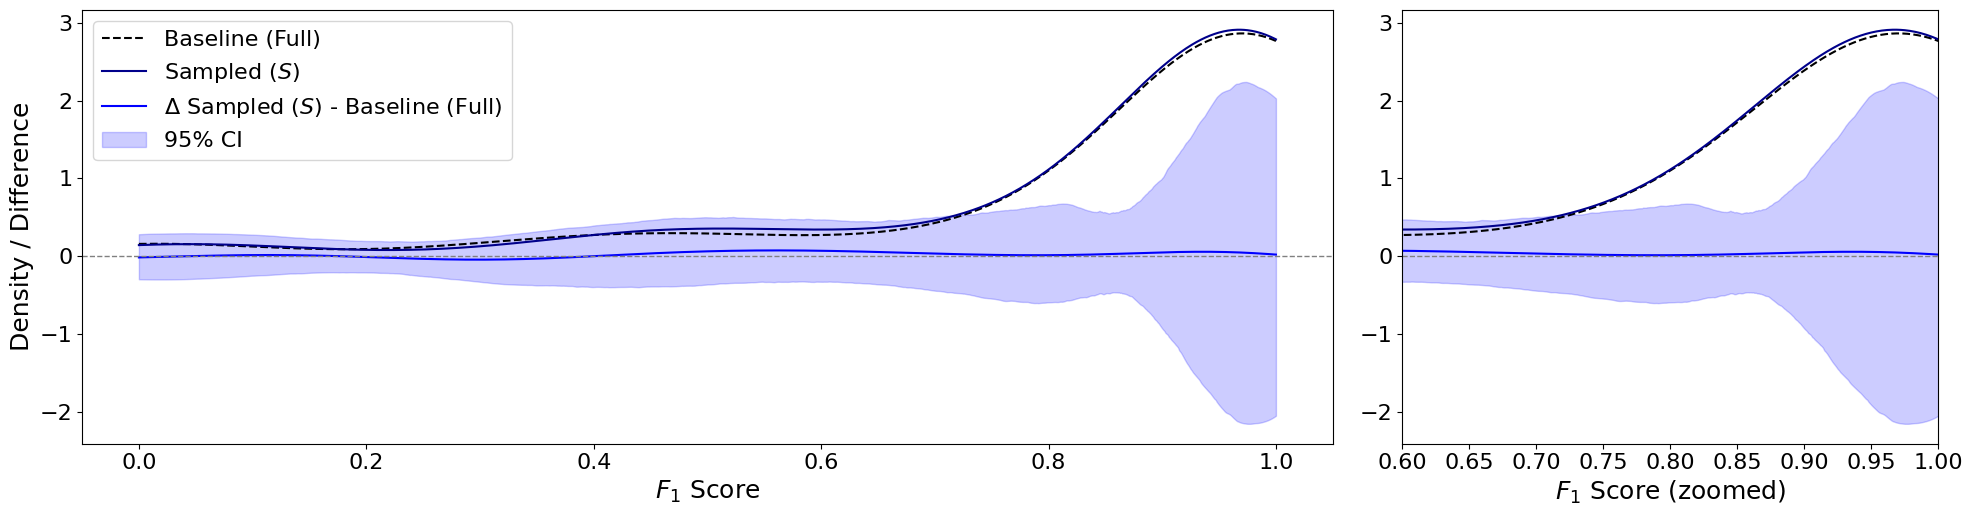

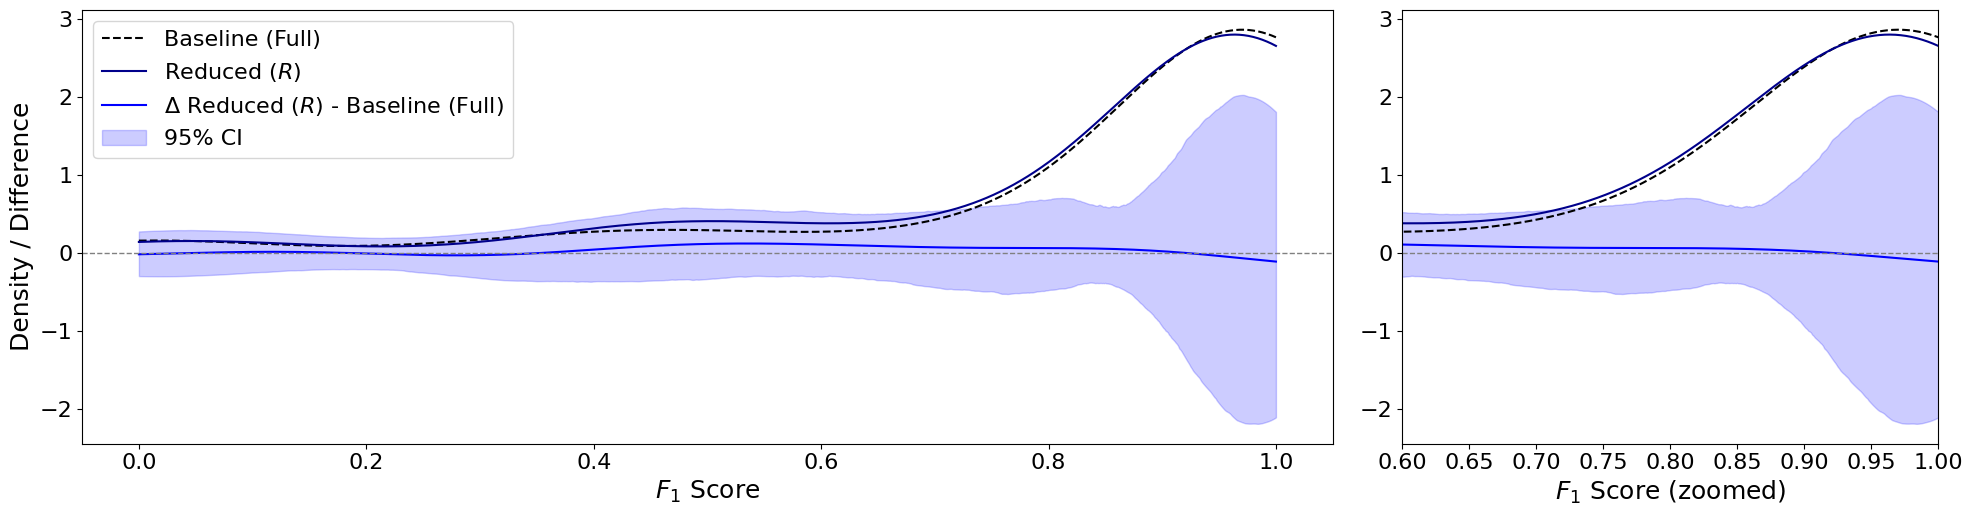

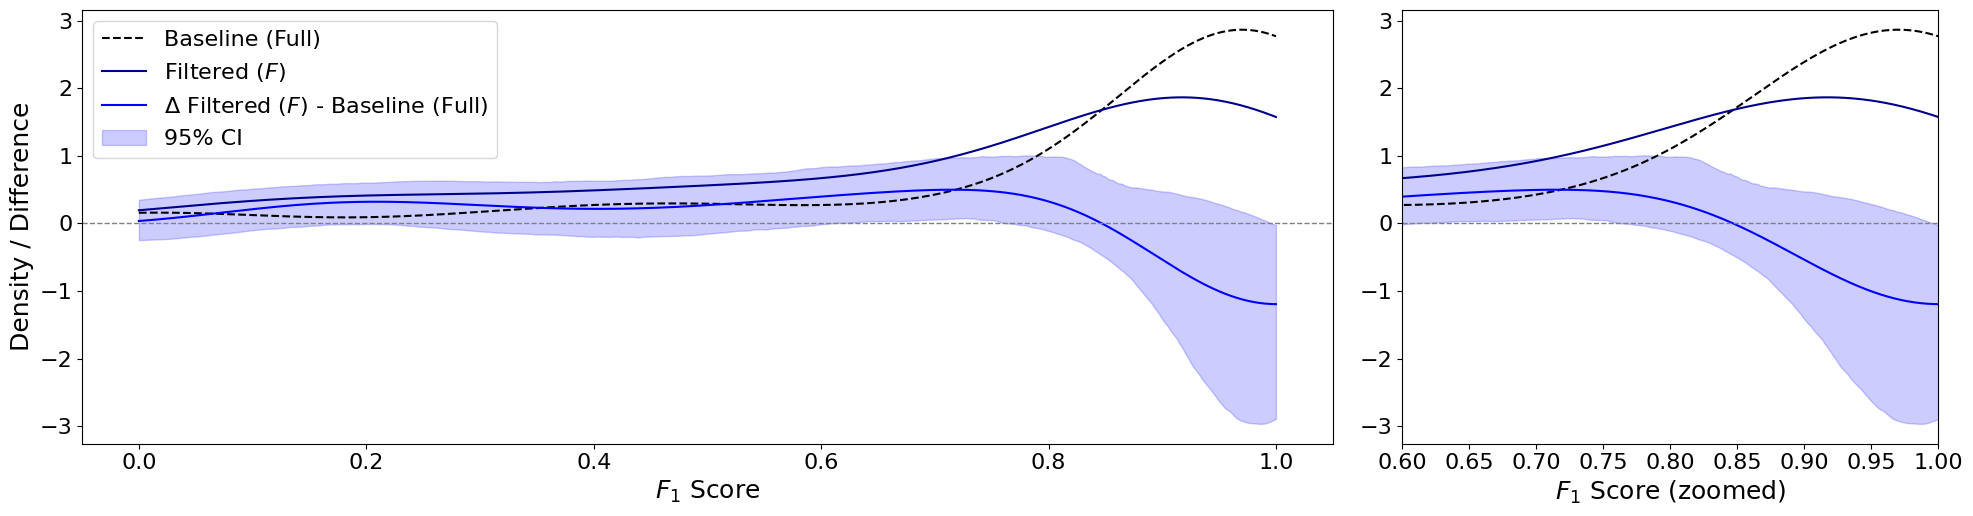

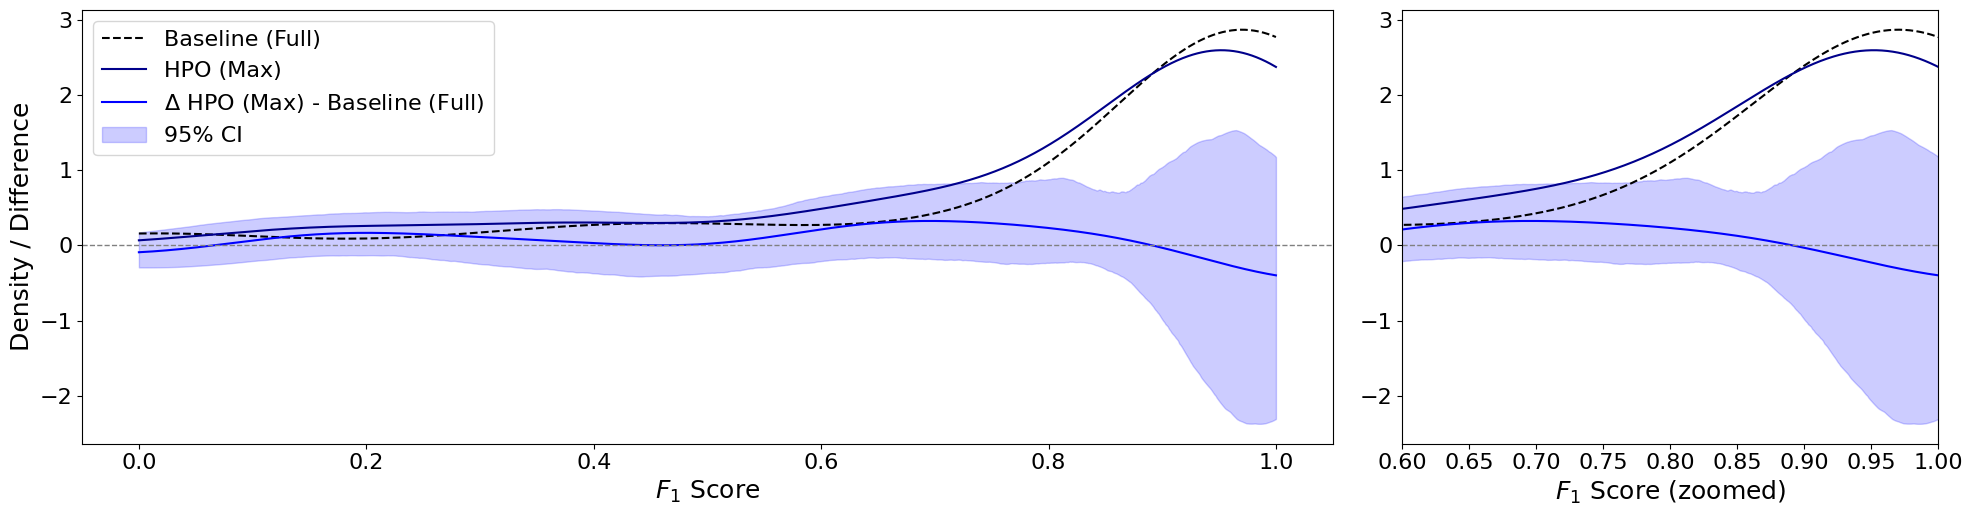

In [20]:
# Setup
ref_col = "f1_full"
columns = [col for col in perf_cols_f1 if col != ref_col]
x_vals = np.linspace(df_numeric[perf_cols_f1].min().min(),
                     df_numeric[perf_cols_f1].max().max(), 1000)

ref_data = df_numeric[ref_col].dropna().values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

col_map = {
    'f1_full': 'Baseline (Full)',
    'f1_sampled': 'Sampled ($S$)',
    'f1_reduced': 'Reduced ($R$)',
    'f1_filtered': 'Filtered ($F$)',
    'f1_hpo_max': 'HPO (Max)'
}

for col in columns:
    target_data = df_numeric[col].dropna().values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower
    
    # Subplots: 70% main, 30% zoomed (shared y)
    fig, (ax_main, ax_zoom) = plt.subplots(
        1, 2,
        figsize=(20, 5.5),
        gridspec_kw={'width_ratios': [7, 3]},
        sharey=True
    )
    
    # Main plot
    ax_main.plot(x_vals, ref_kde, label=f"{col_map[ref_col]}", color='black', linestyle='--')
    ax_main.plot(x_vals, target_kde, label=f"{col_map[col]}", color='darkblue')
    ax_main.plot(x_vals, diff, label=f"$\\Delta$ {col_map[col]} - {col_map[ref_col]}", color='blue')
    ax_main.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")
    ax_main.axhline(0, color='gray', linestyle='--', linewidth=1)
    # ax_main.set_title("Full KDE Comparison")
    ax_main.set_xlabel("$F_1$ Score")
    ax_main.set_ylabel("Density / Difference")
    ax_main.legend(loc='upper left')
    
    # Zoomed plot
    ax_zoom.plot(x_vals, ref_kde, color='black', linestyle='--')
    ax_zoom.plot(x_vals, target_kde, color='darkblue')
    ax_zoom.plot(x_vals, diff, color='blue')
    ax_zoom.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue')
    ax_zoom.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax_zoom.set_xlim(0.6, 1.0)
    # ax_zoom.set_title("Zoomed Region")
    ax_zoom.set_xlabel("$F_1$ Score (zoomed)")
    ax_zoom.tick_params(labelleft=True)
    
    # Save and show
    plt.tight_layout()
    plt.savefig(f"plots/kde_{col}_vs_{ref_col}_zoom.pdf", dpi=300)
    plt.show()
    plt.close()

# KDE Analysis - Training Time

In [21]:
from matplotlib.ticker import FuncFormatter

def si_time_formatter(log_seconds, pos=None):
    """Convert log10(seconds) to SI-formatted string (e.g., ms, s, min)."""
    seconds = 10 ** log_seconds
    if seconds < 1e-6:
        return f"{seconds*1e9:.0f}ns"
    elif seconds < 1e-3:
        return f"{seconds*1e6:.0f}µs"
    elif seconds < 1:
        return f"{seconds*1e3:.0f}ms"
    elif seconds < 60:
        return f"{seconds:.0f}s"
    elif seconds < 3600:
        return f"{seconds/60:.0f}min"
    else:
        return f"{seconds/3600:.1f}h"

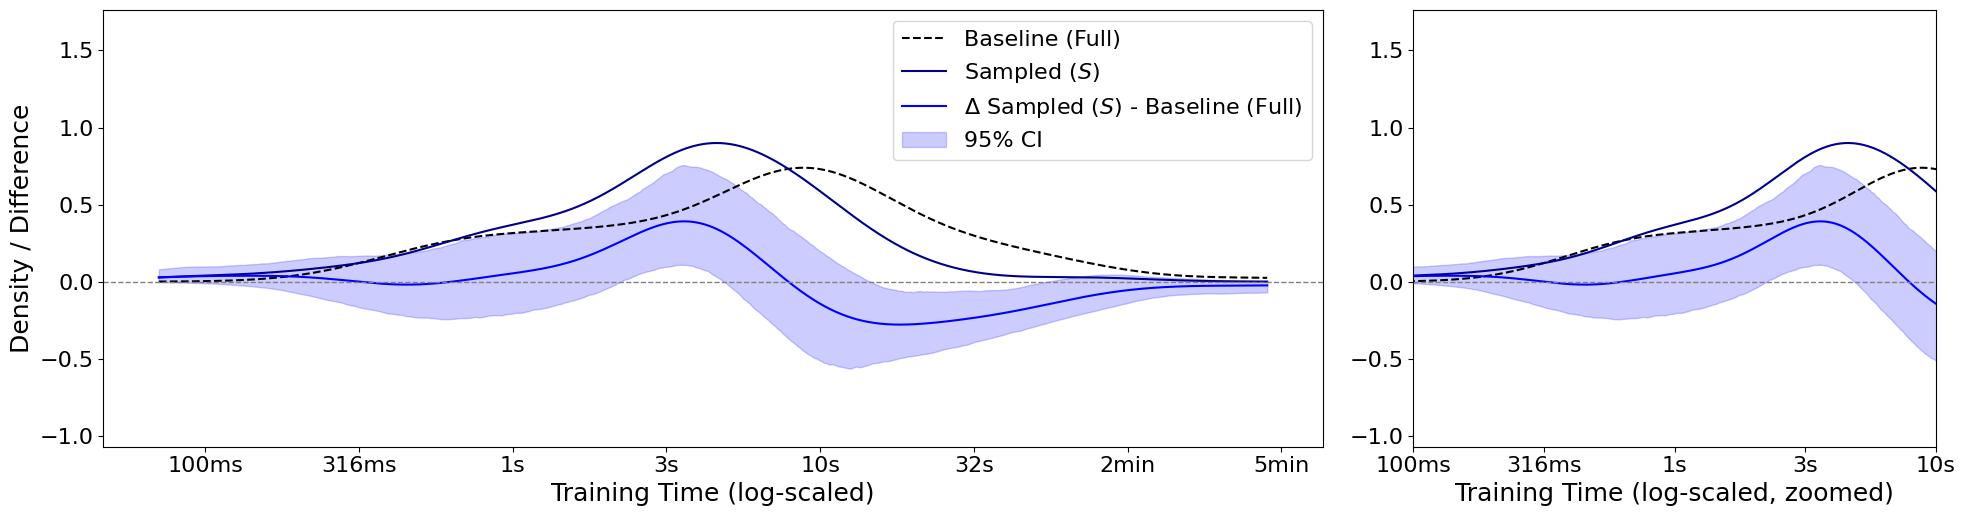

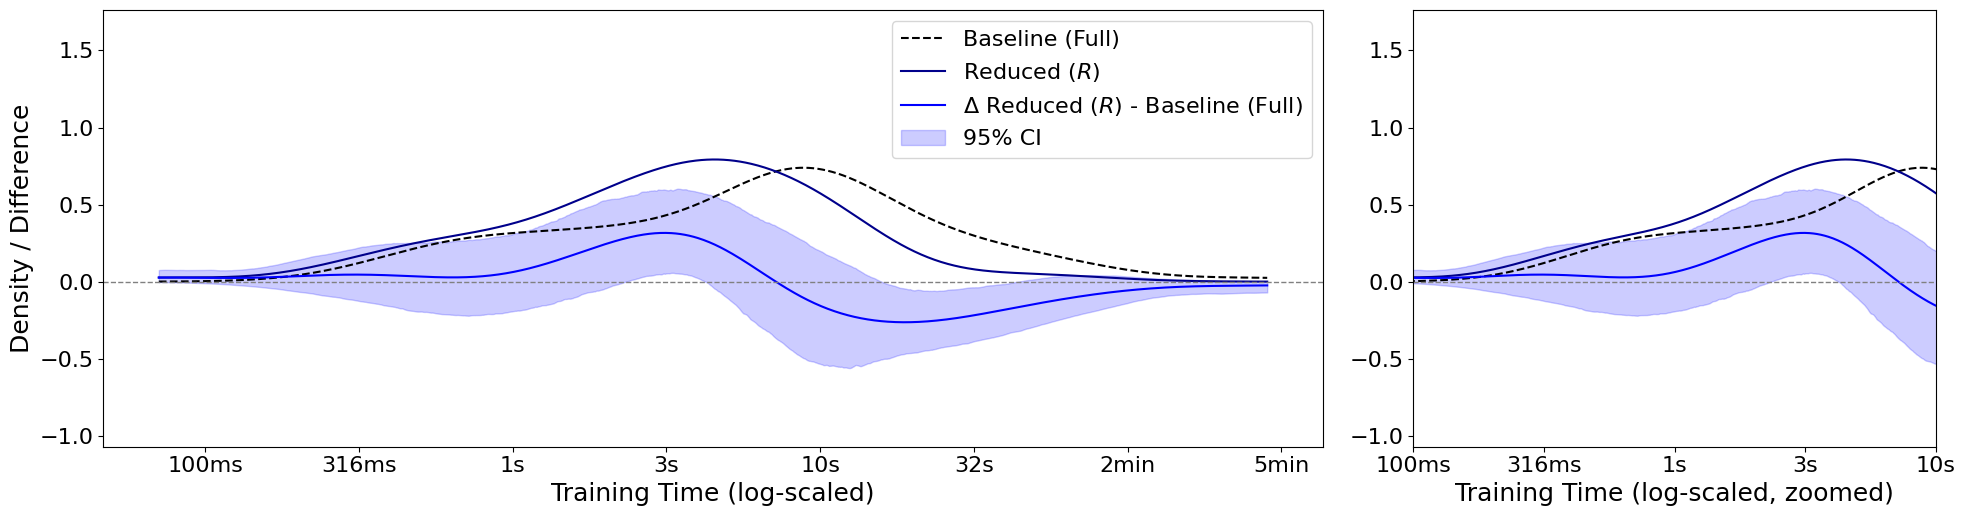

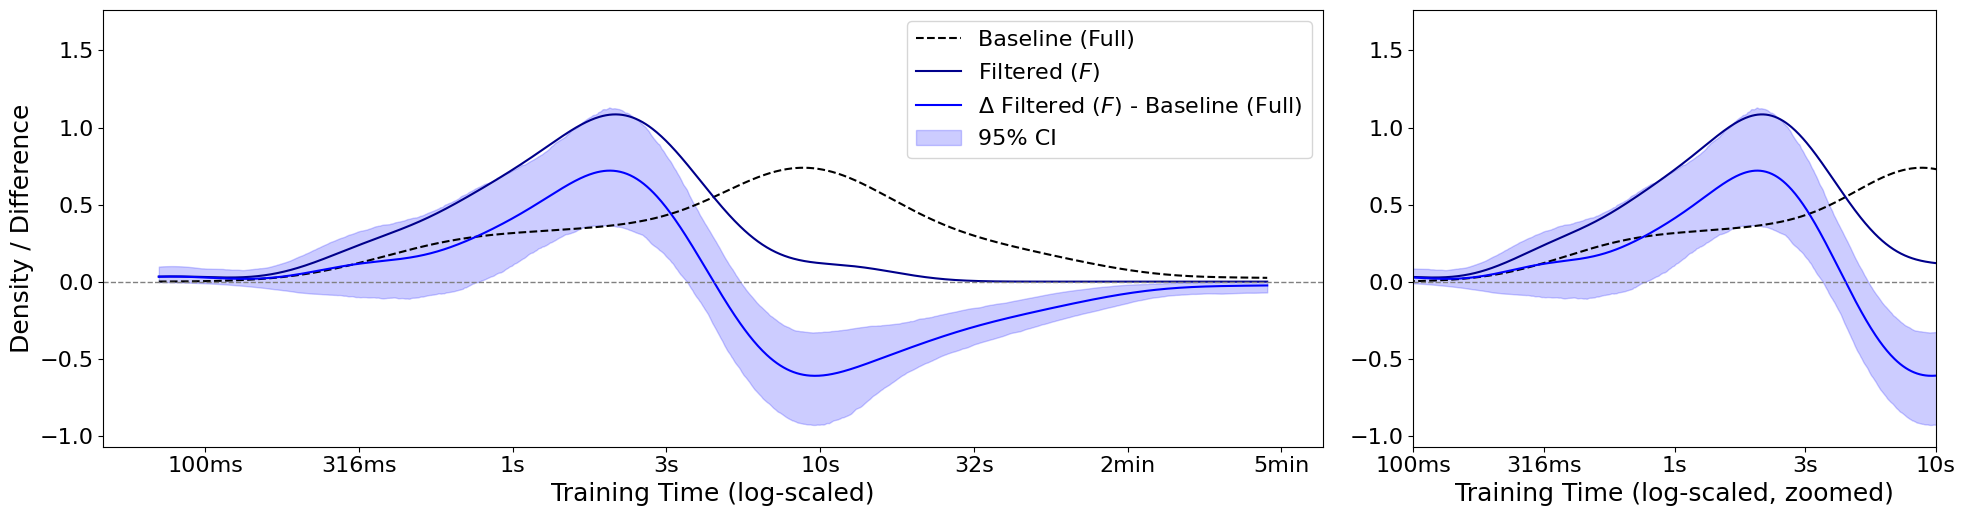

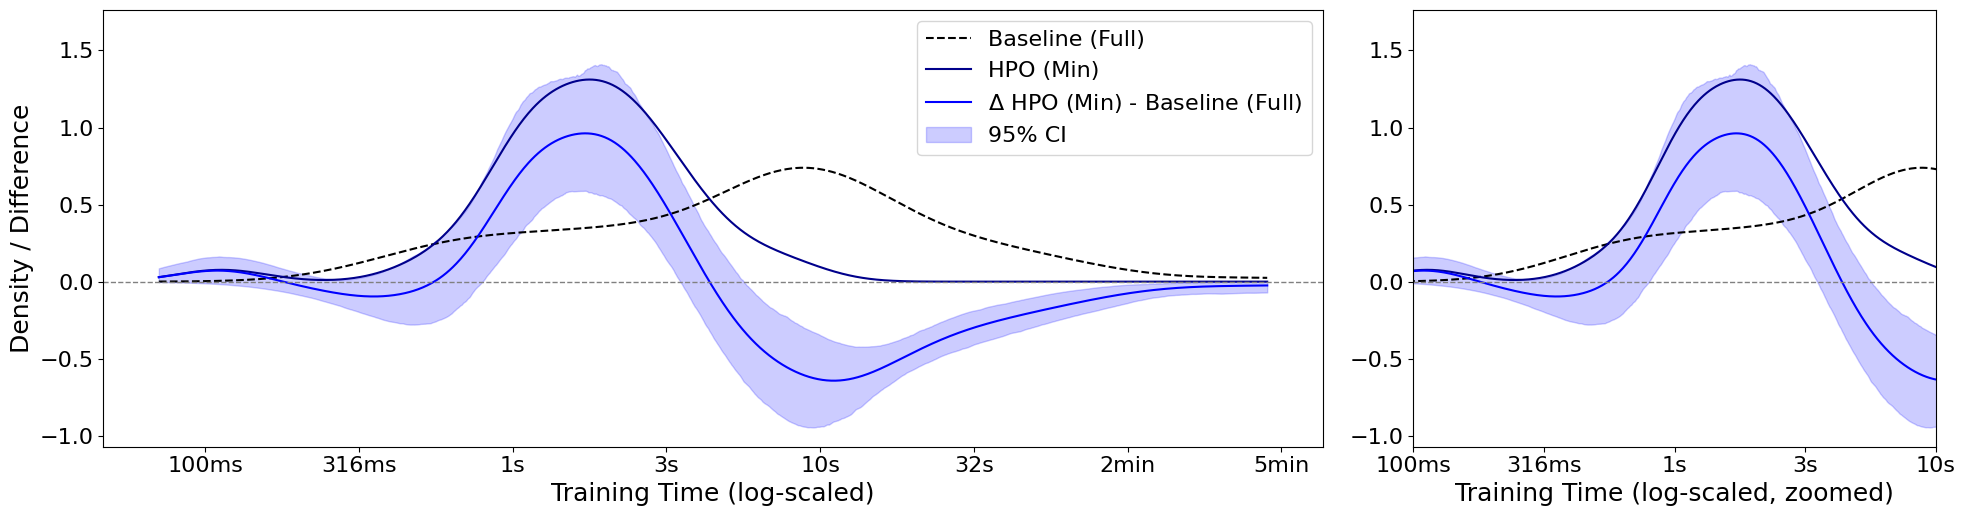

In [22]:
# Create a log10-transformed copy to preserve original data
df_time_log = df_numeric[perf_cols_time].apply(
    lambda col: np.log10(pd.to_numeric(col, errors="coerce"))
)

# Setup
ref_col = "training_time_full"
columns = [col for col in perf_cols_time if col != ref_col]

# Compute KDE support range after log transformation
x_vals = np.linspace(
    df_time_log.min().min(),
    df_time_log.max().max(),
    1000
)

# Reference KDE and CI
ref_data = df_time_log[ref_col].dropna().astype(float).values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

# Precompute all KDE and CI values for global y-limits
all_densities = [ref_kde, ref_lower, ref_upper]

for col in columns:
    target_data = df_time_log[col].dropna().astype(float).values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    all_densities.extend([target_kde, target_lower, target_upper, diff, diff_lower, diff_upper])

# Set consistent y-axis limits with some padding
ymin = min(np.min(arr) for arr in all_densities)
ymax = max(np.max(arr) for arr in all_densities)
pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad

# Labels for plot legend
col_map = {
    'training_time_full': 'Baseline (Full)',
    'training_time_sampled': 'Sampled ($S$)',
    'training_time_reduced': 'Reduced ($R$)',
    'training_time_filtered': 'Filtered ($F$)',
    'training_time_hpo_min': 'HPO (Min)'
}

# Generate KDE plots for each method
for col in columns:
    target_data = df_time_log[col].dropna().astype(float).values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # Subplots: 70% main, 30% zoomed (shared y)
    fig, (ax_main, ax_zoom) = plt.subplots(
        1, 2,
        figsize=(20, 5.5),
        gridspec_kw={'width_ratios': [7, 3]},
        sharey=True
    )

    # Main plot
    ax_main.plot(x_vals, ref_kde, label=f"{col_map[ref_col]}", color='black', linestyle='--')
    ax_main.plot(x_vals, target_kde, label=f"{col_map[col]}", color='darkblue')
    ax_main.plot(x_vals, diff, label=f"$\\Delta$ {col_map[col]} - {col_map[ref_col]}", color='blue')
    ax_main.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")
    ax_main.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax_main.set_xlabel("Training Time (log-scaled)")
    ax_main.set_ylabel("Density / Difference")
    ax_main.set_ylim(ymin, ymax)
    ax_main.legend(loc='upper right')

    # Zoomed plot
    ax_zoom.plot(x_vals, ref_kde, color='black', linestyle='--')
    ax_zoom.plot(x_vals, target_kde, color='darkblue')
    ax_zoom.plot(x_vals, diff, color='blue')
    ax_zoom.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue')
    ax_zoom.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax_zoom.set_xlim(-1.0, 1.0)
    ax_zoom.set_ylim(ymin, ymax)
    ax_zoom.set_xlabel("Training Time (log-scaled, zoomed)")
    ax_zoom.tick_params(labelleft=True)

    ax_main.xaxis.set_major_formatter(FuncFormatter(si_time_formatter))
    ax_zoom.xaxis.set_major_formatter(FuncFormatter(si_time_formatter))
    
    # Save and show
    plt.tight_layout()
    plt.savefig(f"plots/kde_{col}_vs_{ref_col}_zoom.pdf", dpi=300)
    plt.show()
    plt.close()

# KDE Analysis - Latency

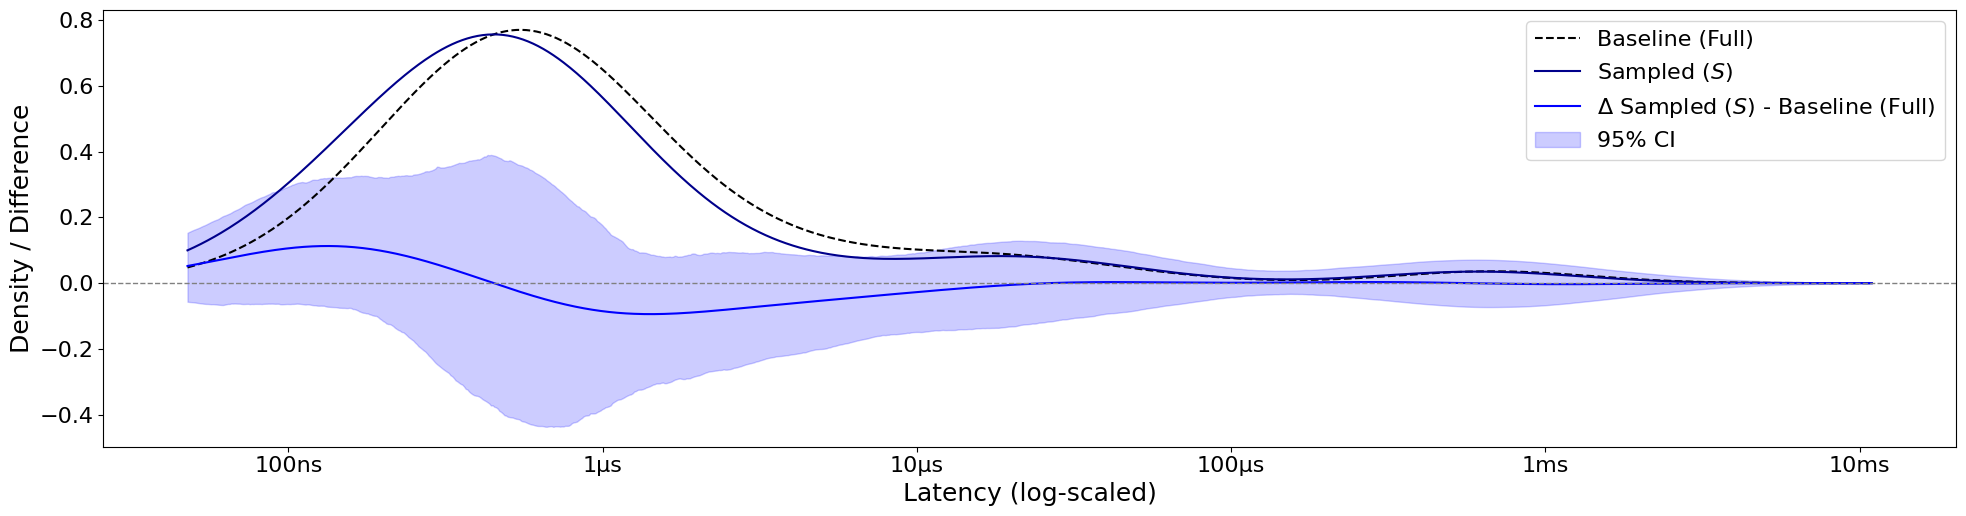

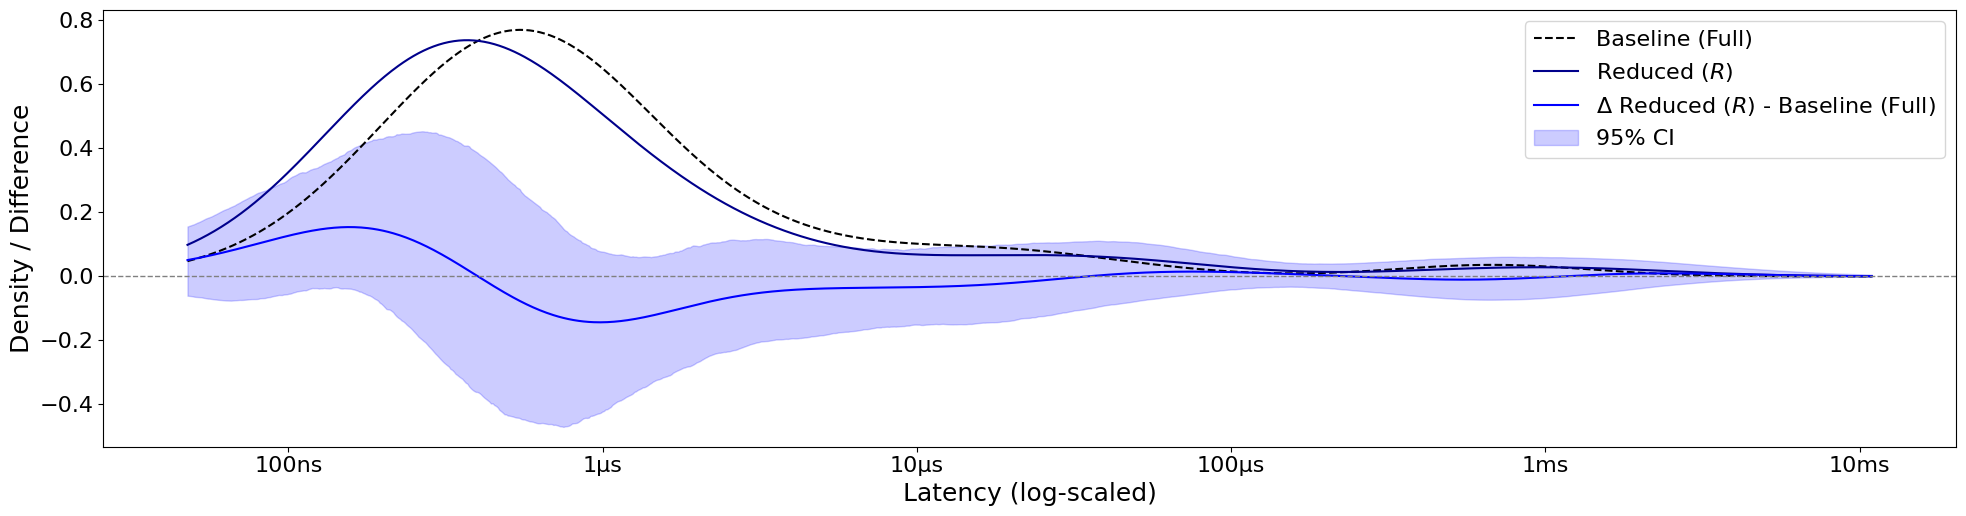

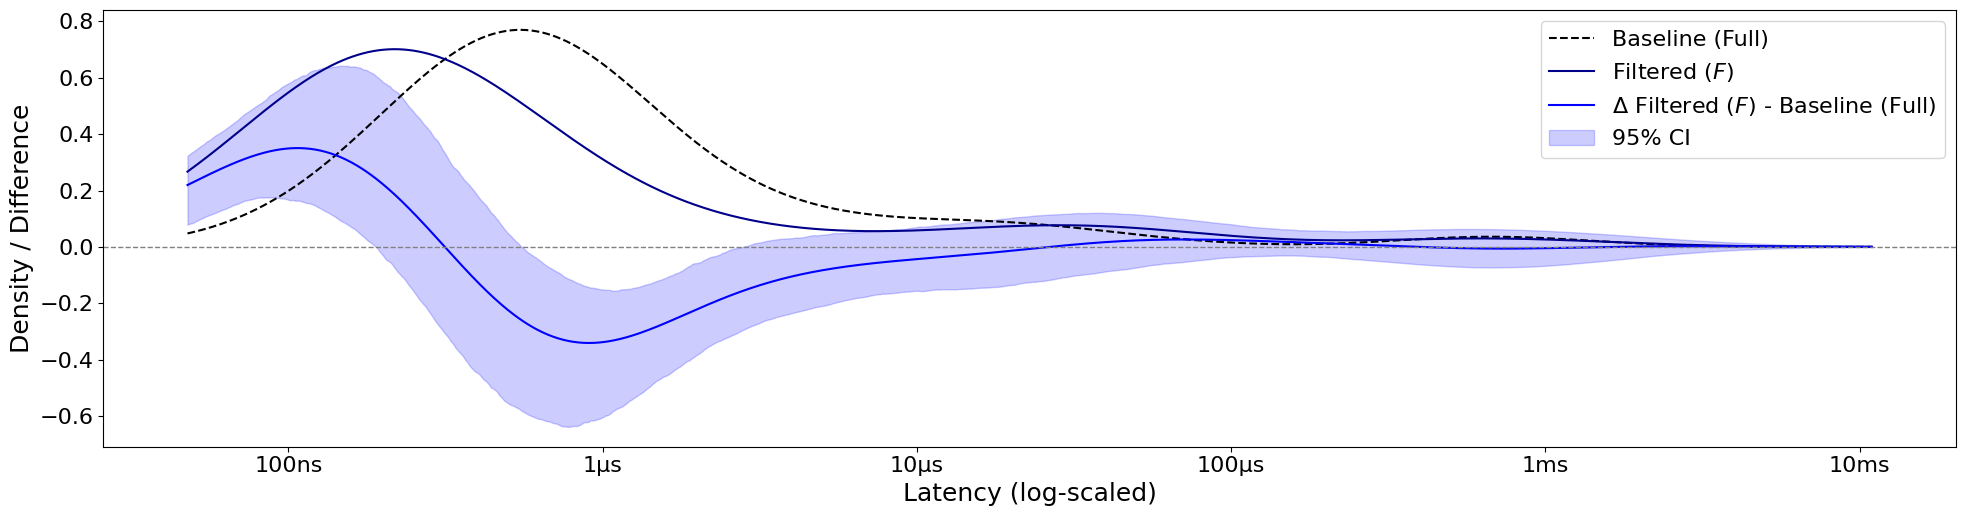

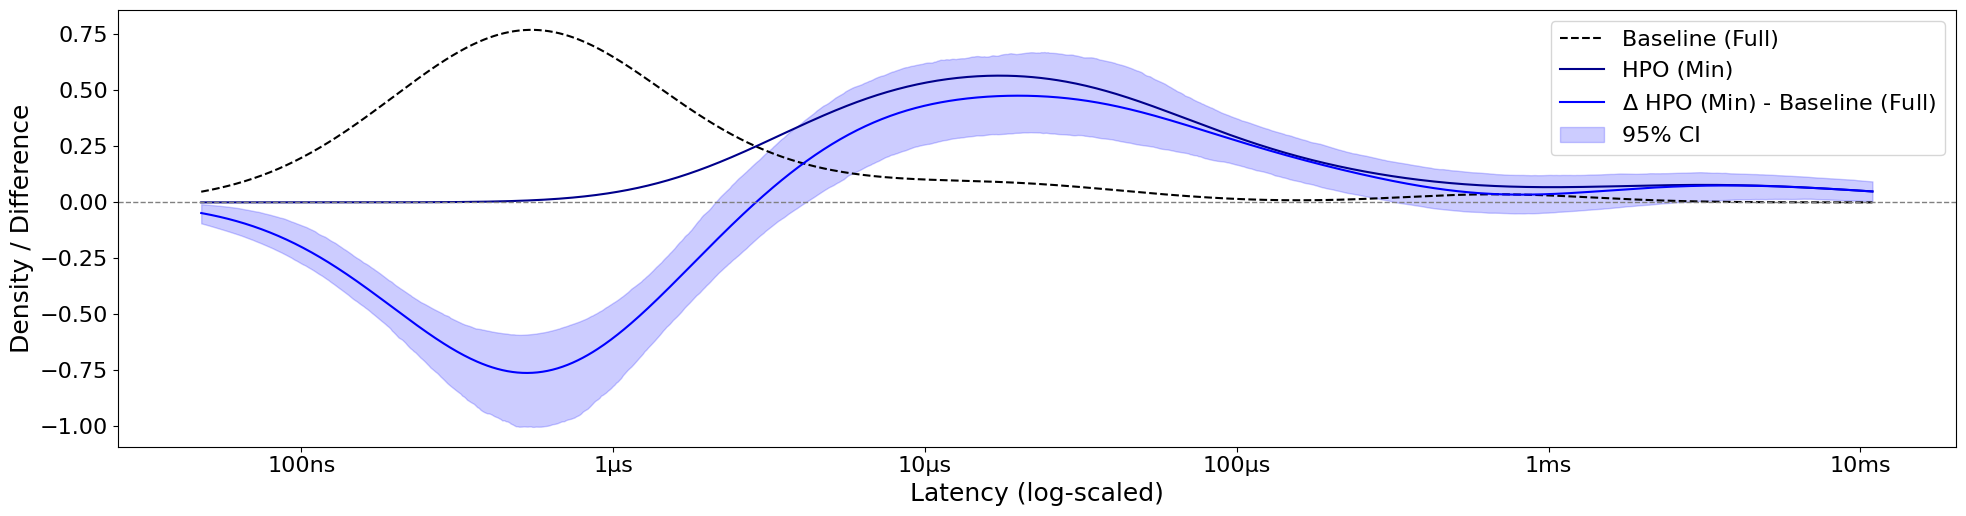

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Define your latency columns
ref_col = "latency_full"
columns = [col for col in perf_cols_latency if col != ref_col]

# Create a log10-transformed copy to preserve original data
df_latency_log = df_numeric[perf_cols_latency].apply(
    lambda col: np.log10(pd.to_numeric(col, errors="coerce"))
)

# Shared x-axis across all latency variants
x_vals = np.linspace(
    df_latency_log.min().min(),
    df_latency_log.max().max(),
    1000
)

# Compute KDE for reference column
ref_data = df_latency_log[ref_col].dropna().astype(float).values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

# Label mapping for plot
col_map = {
    'latency_full': 'Baseline (Full)',
    'latency_sampled': 'Sampled ($S$)',
    'latency_reduced': 'Reduced ($R$)',
    'latency_filtered': 'Filtered ($F$)',
    'latency_hpo_min': 'HPO (Min)'
}

# Loop over all comparison columns
for col in columns:
    target_data = df_latency_log[col].dropna().astype(float).values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # One-panel plot (no zoom)
    fig, ax = plt.subplots(figsize=(20, 5.5))

    ax.plot(x_vals, ref_kde, label=f"{col_map[ref_col]}", color='black', linestyle='--')
    ax.plot(x_vals, target_kde, label=f"{col_map[col]}", color='darkblue')
    ax.plot(x_vals, diff, label=f"$\\Delta$ {col_map[col]} - {col_map[ref_col]}", color='blue')
    ax.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    ax.set_xlabel("Latency (log-scaled)")
    ax.set_ylabel("Density / Difference")
    ax.legend(loc='upper right')

    ax.xaxis.set_major_formatter(FuncFormatter(si_time_formatter))
    
    plt.tight_layout()
    plt.savefig(f"plots/kde_{col}_vs_{ref_col}_latency.pdf", dpi=300)
    plt.show()
    plt.close()

# KDE Analysis - Model Size

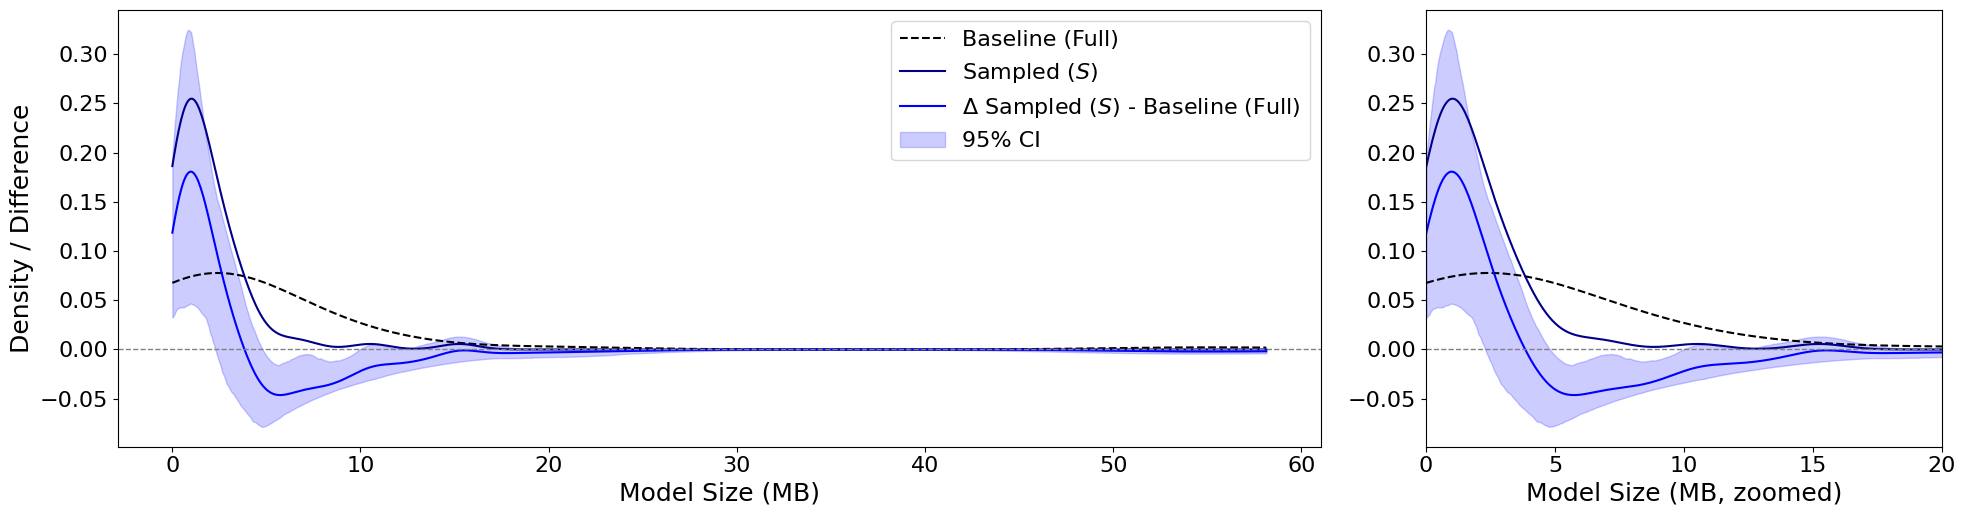

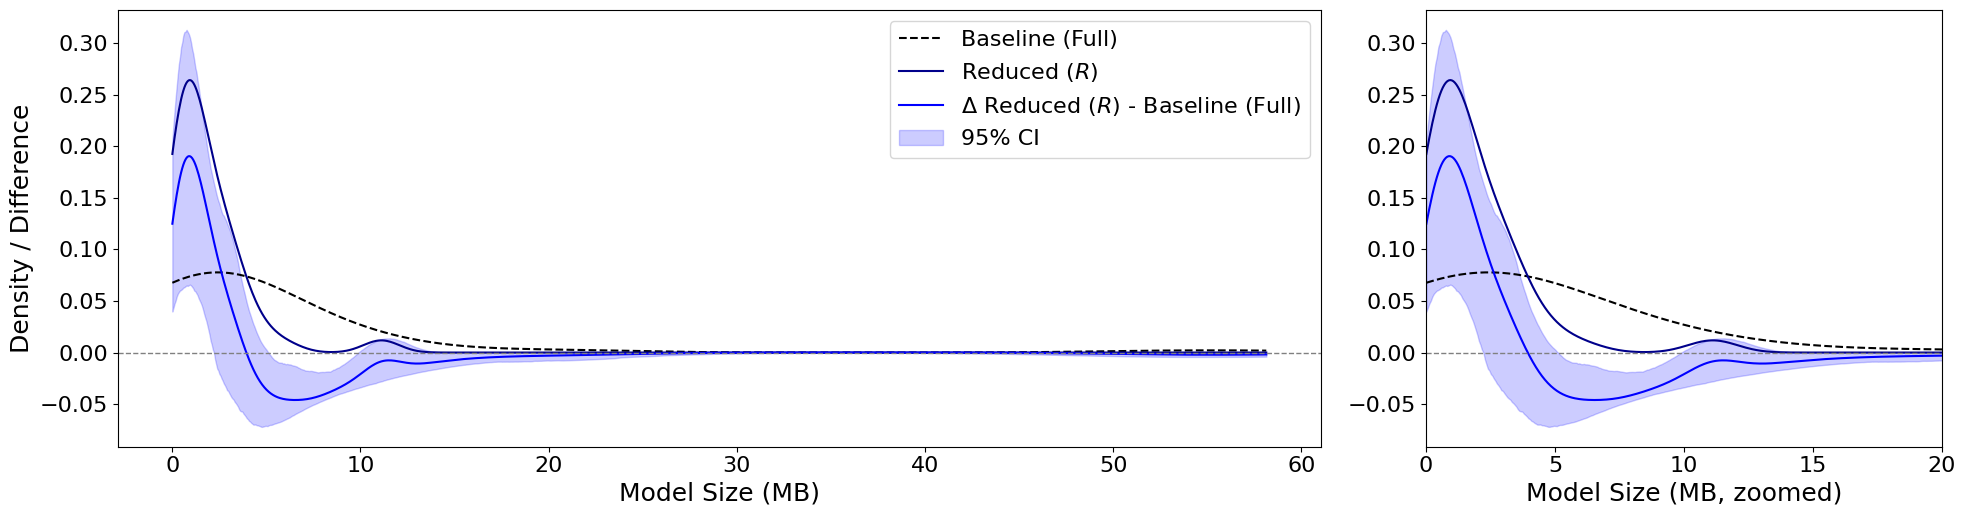

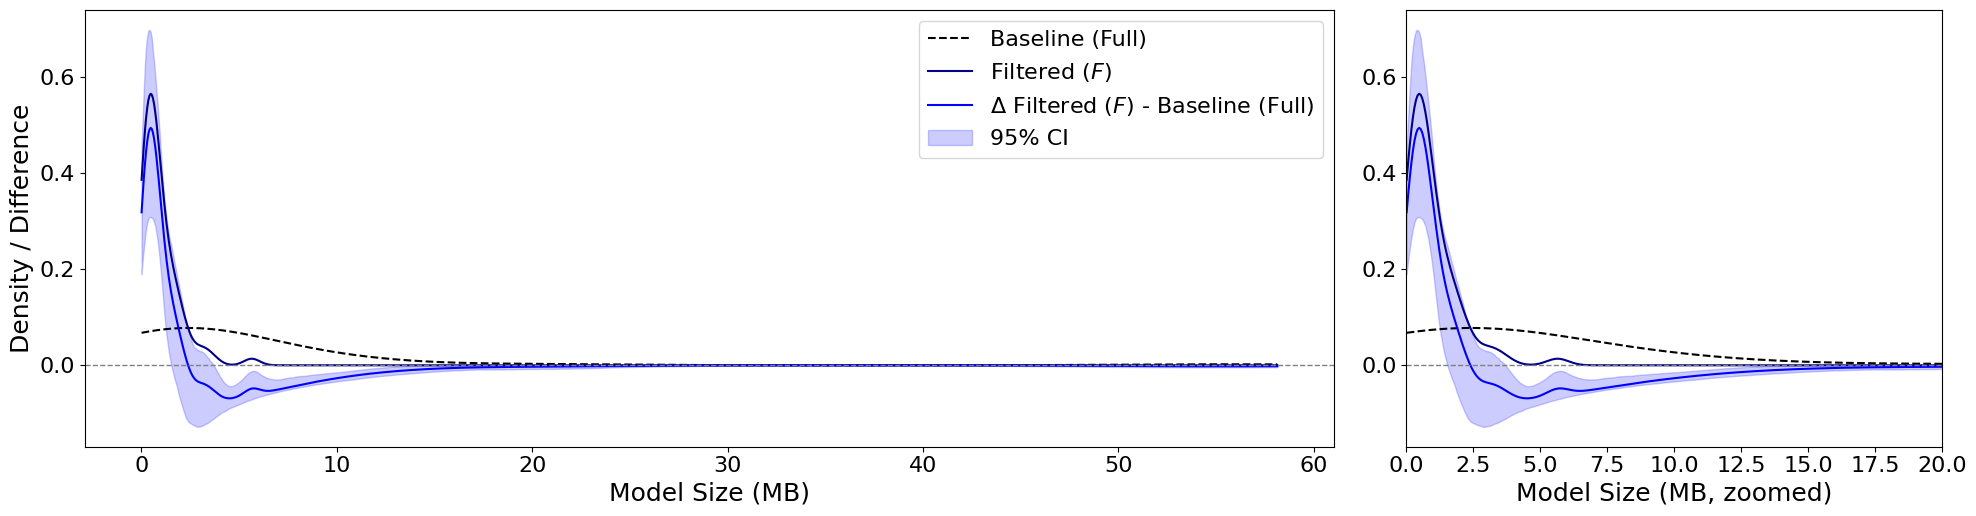

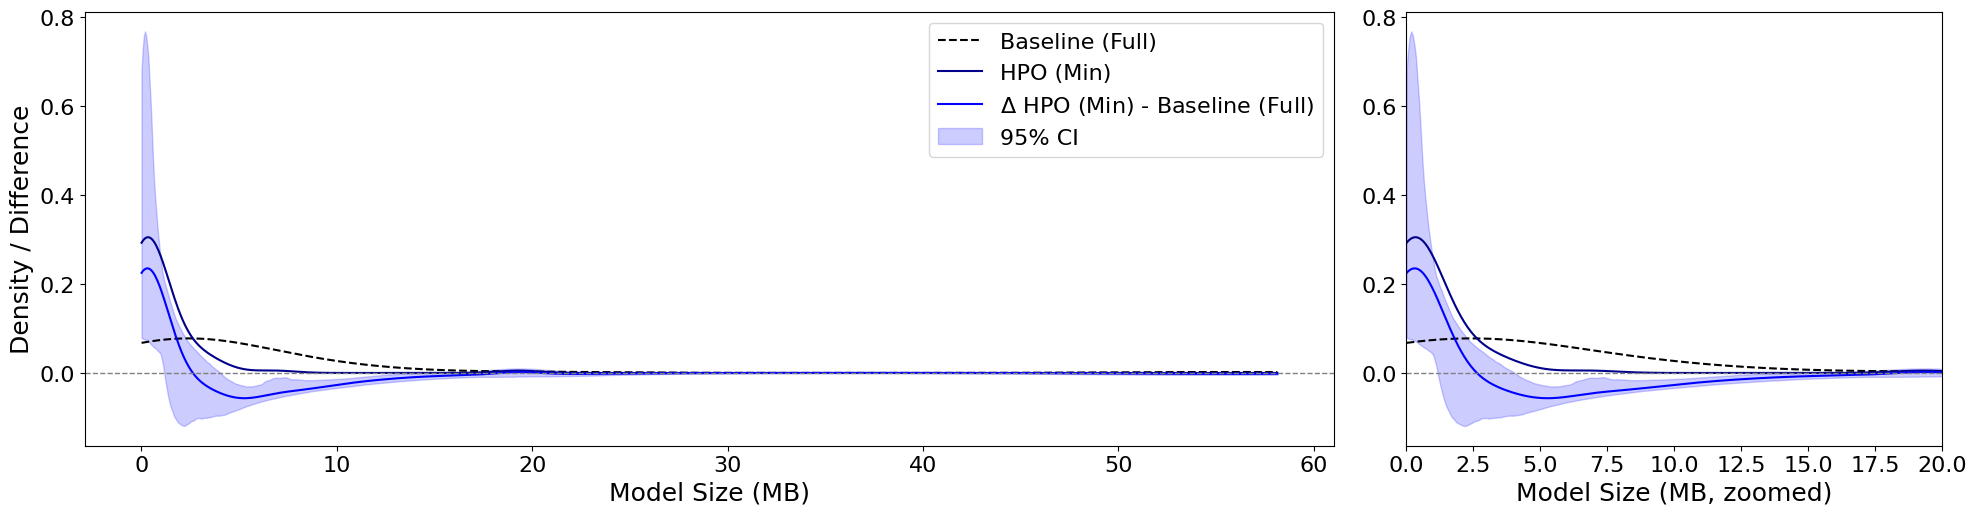

In [24]:
# Setup
ref_col = "model_size_full"
columns = [col for col in perf_cols_size if col != ref_col]
x_vals = np.linspace(df_numeric[perf_cols_size].min().min(),
                     df_numeric[perf_cols_size].max().max(), 1000)

df_numeric["model_size_full"] = pd.to_numeric(df_numeric["model_size_full"], errors="coerce")
ref_data = df_numeric["model_size_full"].dropna().astype(float).values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

col_map = {
    'model_size_full': 'Baseline (Full)',
    'model_size_sampled': 'Sampled ($S$)',
    'model_size_reduced': 'Reduced ($R$)',
    'model_size_filtered': 'Filtered ($F$)',
    'model_size_hpo_min': 'HPO (Min)'
}

for col in columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors="coerce")
    target_data = df_numeric[col].dropna().astype(float).values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # Subplots: 70% main, 30% zoomed (shared y)
    fig, (ax_main, ax_zoom) = plt.subplots(
        1, 2,
        figsize=(20, 5.5),
        sharey=True,  # shared y-axis
        gridspec_kw={'width_ratios': [7, 3]}
    )

    # Main plot
    ax_main.plot(x_vals, ref_kde, label=f"{col_map[ref_col]}", color='black', linestyle='--')
    ax_main.plot(x_vals, target_kde, label=f"{col_map[col]}", color='darkblue')
    ax_main.plot(x_vals, diff, label=f"$\\Delta$ {col_map[col]} - {col_map[ref_col]}", color='blue')
    ax_main.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")
    ax_main.axhline(0, color='gray', linestyle='--', linewidth=1)
    # ax_main.set_title(f"KDE Comparison: {col_map[col]} vs {col_map[ref_col]}")
    ax_main.set_xlabel("Model Size (MB)")
    ax_main.set_ylabel("Density / Difference")
    ax_main.legend(loc='upper right')

    # Zoomed plot
    ax_zoom.plot(x_vals, ref_kde, color='black', linestyle='--')
    ax_zoom.plot(x_vals, target_kde, color='darkblue')
    ax_zoom.plot(x_vals, diff, color='blue')
    ax_zoom.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue')
    ax_zoom.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax_zoom.set_xlim(0, 20)
    # ax_zoom.set_title("Zoomed Region")
    ax_zoom.set_xlabel("Model Size (MB, zoomed)")
    ax_zoom.tick_params(labelleft=True)

    # Save and show
    plt.tight_layout()
    plt.savefig(f"plots/kde_{col}_vs_{ref_col}_zoom.pdf", dpi=300)
    plt.show()
    plt.close()

In [25]:
def summarize_results(df_filename, results_filename):
    df = pd.read_excel(results_filename)
    row_full = df.loc[df['Unnamed: 0'] == 'full', 'X_train_shape'].values[0]
    row_max = df.loc[df['f1_score_abs'].idxmax()].to_dict()
    if 'Unnamed: 0' in row_max:
        row_max['best_config'] = row_max.pop('Unnamed: 0')
    summary = {'filename': df_filename, 'shape': row_full,}
    summary.update(row_max)
    return summary

In [26]:
base_folder = Path("/home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass_3600")

summary_rows = []

# Find all .parquet files recursively
result_files = list(base_folder.rglob("*table.xlsx"))

# Iterate
for file in tqdm(result_files, desc='File', leave='False'):

    try:
        short_filename = str(file.parent.stem)
        row = summarize_results(short_filename, file)
        summary_rows.append(row)
        
    except (ValueError, Exception) as e:
        tqdm.write(f'[{now()}] ERROR      | FILE = {str(file.stem):<64} | EXCEPTION = {e}')

File:   0%|          | 0/73 [00:00<?, ?it/s]

In [27]:
output_df = pd.DataFrame(summary_rows).set_index("filename")

output_df

,shape,X_train_shape,X_val_shape,X_test_shape,model_size_abs,model_size_delta,training_time_abs,training_time_delta,latency_abs,latency_delta,f1_score_abs,f1_score_delta,hpo_n_trials,hpo_params,best_config
filename,,,,,,,,,,,,,,,
CICEVSE2024_EVSE-B_Macro_Multiclass,"(171987, 68)","(17190, 68)","(57329, 68)","(57329, 68)",1.36,-0.48 (-26.09%),4.317,-1.812424 (-29.57%),6.000530e-07,+1.24e-07 (+26.07%),0.948975,+0.001143 (+0.11%),--,--,sampled
NIDS_NF-ToN-IoT-v2_Multiclass,"(699477, 38)","(699477, 38)","(233159, 38)","(233158, 38)",10.85,+0.00 (+0.00%),54.622,--,1.061390e-06,--,0.887541,--,--,--,full
ToN_IoT_Network_Multiclass,"(282243, 40)","(282243, 40)","(94081, 40)","(94081, 40)",6.51,+0.00 (+0.00%),14.339,--,6.300310e-07,--,0.982596,--,--,--,full
N_BaIoT_SimpleHome_XCS7_1003_WHT_Security_Camera_Multiclass,"(329363, 115)","(329363, 115)","(109788, 115)","(109787, 115)",2.39,+0.00 (+0.00%),8.923,--,9.033960e-07,--,0.999852,--,--,--,full
NIDS_NF-BoT-IoT-v2_Multiclass,"(85853, 38)","(85853, 38)","(28617, 38)","(28617, 38)",8.56,+0.00 (+0.00%),9.711,--,1.030006e-06,--,0.907984,--,--,--,full
CICIoMT2024_Bluetooth_Multiclass,"(449, 7)","(449, 7)","(149, 7)","(149, 7)",0.05,+0.00 (+0.00%),0.437,--,1.547641e-05,--,0.704818,--,--,--,full
BCCC_CIC-BCCC-NRC-IoT-2022_Multiclass,"(55073, 72)","(55073, 72)","(18357, 72)","(18357, 72)",0.07,+0.00 (+0.00%),0.694,--,2.251450e-07,--,0.999945,--,--,--,full
NIDS_CIC-ToN-IoT_Multiclass,"(101735, 71)","(10176, 31)","(33911, 31)","(33911, 31)",0.93,-0.53 (-36.30%),2.046,-1.460774 (-41.66%),3.462140e-07,-9.39e-08 (-21.33%),0.880905,+0.010080 (+1.01%),--,--,reduced
N_BaIoT_Philips_B120N10_Baby_Monitor_Multiclass,"(471723, 115)","(471723, 115)","(157241, 115)","(157240, 115)",2.32,+0.00 (+0.00%),8.593,--,3.320130e-07,--,0.999910,--,--,--,full
